# **Data Pre-Processing:**

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
import os


In [ ]:
# Step 2: Load the data to Google Colab (Optional)
#from google.colab import files
#uploaded = files.upload()


In [ ]:

# # Folder containing the CSV files
# data_folder = 'Data/'

# # Get all files
# all_files = glob.glob(os.path.join(data_folder, "*.csv"))

# # Separate Div_s_Room files and Transmitter_Data files
# room_files = [f for f in all_files if not os.path.basename(f).startswith('Transmitter_Data_for_')]
# transmitter_files = {os.path.basename(f).replace('Transmitter_Data_for_', ''): f for f in all_files if os.path.basename(f).startswith('Transmitter_Data_for_')}

# print(f"Room Files: {room_files}")
# print(f"Transmitter Files: {transmitter_files}")

# # Process each room file and its matching transmitter file
# for room_file in room_files:
#     file_name = os.path.basename(room_file)

#     # Check if matching transmitter file exists
#     if file_name not in transmitter_files:
#         print(f"No matching transmitter file found for {file_name}, skipping...")
#         continue

#     transmitter_file = transmitter_files[file_name]
#     print(f"Processing {file_name} with {os.path.basename(transmitter_file)}")

#     # Load both files
#     data = pd.read_csv(room_file)
#     transmitter_data = pd.read_csv(transmitter_file)

#     # Standardize column names to lowercase and strip spaces
#     data.columns = data.columns.str.strip().str.lower()
#     transmitter_data.columns = transmitter_data.columns.str.strip().str.lower()

#     # Ensure timestamps are in datetime format (adapt the format if needed)
#     data['timestamp'] = pd.to_datetime(data['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
#     transmitter_data['timestamp'] = pd.to_datetime(transmitter_data['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

#     # Merge transmitter data into room data
#     merged_data = pd.merge(
#         data,
#         transmitter_data[['timestamp', 'signal strength', 'download speed']],
#         on='timestamp',
#         how='left'
#     )

#     # Rename for clarity with "Transmitter's" prefix
#     merged_data.rename(columns={
#         'signal strength': "Transmitter's Signal Strength",
#         'download speed': "Transmitter's Download Speed"
#     }, inplace=True)

#     # Save the processed file
#     output_file = os.path.join(data_folder, f'processed_{file_name}')
#     merged_data.to_csv(output_file, index=False)

#     print(f"Saved processed file to {output_file}")

# print("Batch processing completed.")

Room Files: ['Data/processed_Shirish_s_Room.csv', 'Data/My_Room.csv', 'Data/processed_My_Room.csv', 'Data/Shirish_s_Room.csv', 'Data/My_Bathroom.csv', 'Data/Hall.csv', 'Data/Div_s_Bathroom.csv', 'Data/Div_s_Room.csv', 'Data/processed_Div_s_Bathroom.csv', 'Data/processed_My_Bathroom.csv', 'Data/processed_Hall.csv', 'Data/processed_Div_s_Room.csv']
Transmitter Files: {'My_Room.csv': 'Data/Transmitter_Data_for_My_Room.csv', 'Shirish_s_Room.csv': 'Data/Transmitter_Data_for_Shirish_s_Room.csv', 'Hall.csv': 'Data/Transmitter_Data_for_Hall.csv', 'My_Bathroom.csv': 'Data/Transmitter_Data_for_My_Bathroom.csv', 'Div_s_Room.csv': 'Data/Transmitter_Data_for_Div_s_Room.csv', 'Div_s_Bathroom.csv': 'Data/Transmitter_Data_for_Div_s_Bathroom.csv'}
No matching transmitter file found for processed_Shirish_s_Room.csv, skipping...
Processing My_Room.csv with Transmitter_Data_for_My_Room.csv
Saved processed file to Data/processed_My_Room.csv
No matching transmitter file found for processed_My_Room.csv, skip

In [ ]:
import os
import glob
import pandas as pd

# Folder containing the CSV files
data_folder = 'Data/'

# Get all CSV files in the folder
all_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Separate room and transmitter files
room_files = [f for f in all_files if not os.path.basename(f).startswith('Transmitter_Data_for_')]
transmitter_files = {os.path.basename(f).replace('Transmitter_Data_for_', ''): f
                     for f in all_files if os.path.basename(f).startswith('Transmitter_Data_for_')}

print(f"Room Files: {room_files}")
print(f"Transmitter Files: {transmitter_files}")

for room_file in room_files:
    file_name = os.path.basename(room_file)
    if file_name not in transmitter_files:
        print(f"No matching transmitter file found for {file_name}, skipping...")
        continue

    transmitter_file = transmitter_files[file_name]
    print(f"Processing {file_name} with {os.path.basename(transmitter_file)}")

    # Load both files
    room_df = pd.read_csv(room_file)
    tx_df = pd.read_csv(transmitter_file)

    # Standardize column names
    room_df.columns = room_df.columns.str.strip().str.lower()
    tx_df.columns = tx_df.columns.str.strip().str.lower()

    # Parse timestamps (try both common formats)
    for df in [room_df, tx_df]:
        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
                df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

                df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
            except:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Drop rows with invalid timestamps
    room_df = room_df.dropna(subset=['timestamp'])
    tx_df = tx_df.dropna(subset=['timestamp'])

    # Sort by timestamp for merge_asof
    room_df = room_df.sort_values('timestamp').reset_index(drop=True)
    tx_df = tx_df.sort_values('timestamp').reset_index(drop=True)

    # Use merge_asof for nearest timestamp matching (within 1 minute tolerance)
    merged = pd.merge_asof(
        room_df,
        tx_df[['timestamp', 'signal strength', 'download speed']],
        on='timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('1min')
    )

    # Rename for clarity
    merged.rename(columns={
        'signal strength_y': "Transmitter Signal Strength",
        'download speed_y': "Transmitter Download Speed",
        'signal strength_x': "Signal Strength",
        'download speed_x': "Download Speed",
    }, inplace=True)

    # Save the processed file
    output_file = os.path.join(data_folder, f'processed_{file_name}')
    merged.to_csv(output_file, index=False)
    print(f"Saved processed file to {output_file}")

print("Batch processing completed.")


Room Files: ['Data/processed_Shirish_s_Room.csv', 'Data/My_Room.csv', 'Data/processed_My_Room.csv', 'Data/Shirish_s_Room.csv', 'Data/My_Bathroom.csv', 'Data/Hall.csv', 'Data/aggregated_Shirish_s_Room.csv', 'Data/aggregated_My_Bathroom.csv', 'Data/Div_s_Bathroom.csv', 'Data/aggregated_My_Room.csv', 'Data/aggregated_Hall.csv', 'Data/Div_s_Room.csv', 'Data/processed_Div_s_Bathroom.csv', 'Data/aggregated_Div_s_Room.csv', 'Data/aggregated_Div_s_Bathroom.csv', 'Data/processed_My_Bathroom.csv', 'Data/processed_Hall.csv', 'Data/processed_Div_s_Room.csv']
Transmitter Files: {'My_Room.csv': 'Data/Transmitter_Data_for_My_Room.csv', 'Shirish_s_Room.csv': 'Data/Transmitter_Data_for_Shirish_s_Room.csv', 'Hall.csv': 'Data/Transmitter_Data_for_Hall.csv', 'My_Bathroom.csv': 'Data/Transmitter_Data_for_My_Bathroom.csv', 'Div_s_Room.csv': 'Data/Transmitter_Data_for_Div_s_Room.csv', 'Div_s_Bathroom.csv': 'Data/Transmitter_Data_for_Div_s_Bathroom.csv'}
No matching transmitter file found for processed_Shiris

<ipython-input-20-00cd28f3f054>:45: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [ ]:

# Get all processed files
processed_files = glob.glob(os.path.join(data_folder, "processed_*.csv"))

for processed_file in processed_files:
    print(f"Cleaning {processed_file}...")

    data = pd.read_csv(processed_file)

    # Standardize column names (in case they shifted)
    data.columns = data.columns.str.strip()

    # Replace "Unknown" with NaN
    data.replace("Unknown", np.nan, inplace=True)

    # Drop completely empty columns
    data.dropna(axis=1, how='all', inplace=True)

    # Drop columns you know are unwanted (adjust if needed)
    unwanted_columns = ['Unnamed: 9', 'unnamed: 9', 'Unnamed: 10', 'Download Speed (Additional)', 'Signal Strength (Additional)']
    data.drop(columns=[col for col in unwanted_columns if col in data.columns], errors='ignore', inplace=True)

    # Clean numeric columns (remove non-numeric characters like 'dBm' or 'Mbps')
    if 'Signal Strength' in data.columns:
        data['Signal Strength'] = data['Signal Strength'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
        data['Signal Strength'] = pd.to_numeric(data['Signal Strength'], errors='coerce')

    if 'Download Speed' in data.columns:
        data['Download Speed'] = data['Download Speed'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
        data['Download Speed'] = pd.to_numeric(data['Download Speed'], errors='coerce')

    if 'Transmitter Signal Strength' in data.columns:
        data['Transmitter Signal Strength'] = data['Transmitter Signal Strength'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
        data['Transmitter Signal Strength'] = pd.to_numeric(data['Transmitter Signal Strength'], errors='coerce')

    if 'Transmitter Download Speed' in data.columns:
        data['Transmitter Download Speed'] = data['Transmitter Download Speed'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
        data['Transmitter Download Speed'] = pd.to_numeric(data['Transmitter Download Speed'], errors='coerce')

    # (Optional) Combine x & y coordinates for quick lookup
    if 'Pixel Latitude (X)'.lower() in data.columns and 'Pixel Longitude (Y)'.lower() in data.columns:
        data['Coordinate'] = data['Pixel Latitude (X)'.lower()].astype(str) + ',' + data['Pixel Longitude (Y)'.lower()].astype(str)

    # (Optional) Group by coordinate to calculate averages (remove if you don't want aggregation here)
    if 'Coordinate' in data.columns:
        aggregated_data = data.groupby('Coordinate').agg(
            Pixel_Latitude_X=('Pixel Latitude (X)'.lower(), 'first'),
            Pixel_Longitude_Y=('Pixel Longitude (Y)'.lower(), 'first'),
            Network_Type=('Network Type'.lower(), 'first'),
            avg_signal_strength_dBm=('Signal Strength', 'mean'),
            avg_download_speed_Mbps=('Download Speed', 'mean'),
            avg_transmitter_signal_strength_dBm=('Transmitter Signal Strength', 'mean'),
            avg_transmitter_download_speed_Mbps=('Transmitter Download Speed', 'mean')
        ).reset_index()

        # Save aggregated version if needed
        aggregated_output_file = processed_file.replace('processed_', 'aggregated_')
        aggregated_data.to_csv(aggregated_output_file, index=False)
        print(f"Aggregated data saved to {aggregated_output_file}")

    # Save cleaned processed file (overwrite original processed file if desired)
    data.to_csv(processed_file, index=False)
    print(f"Cleaned data saved to {processed_file}\n")

print("All processed files cleaned and saved.")


Cleaning Data/processed_Shirish_s_Room.csv...
Aggregated data saved to Data/aggregated_Shirish_s_Room.csv
Cleaned data saved to Data/processed_Shirish_s_Room.csv

Cleaning Data/processed_My_Room.csv...
Aggregated data saved to Data/aggregated_My_Room.csv
Cleaned data saved to Data/processed_My_Room.csv

Cleaning Data/processed_Div_s_Bathroom.csv...
Aggregated data saved to Data/aggregated_Div_s_Bathroom.csv
Cleaned data saved to Data/processed_Div_s_Bathroom.csv

Cleaning Data/processed_My_Bathroom.csv...
Aggregated data saved to Data/aggregated_My_Bathroom.csv
Cleaned data saved to Data/processed_My_Bathroom.csv

Cleaning Data/processed_Hall.csv...
Aggregated data saved to Data/aggregated_Hall.csv
Cleaned data saved to Data/processed_Hall.csv

Cleaning Data/processed_Div_s_Room.csv...
Aggregated data saved to Data/aggregated_Div_s_Room.csv
Cleaned data saved to Data/processed_Div_s_Room.csv

All processed files cleaned and saved.


<ipython-input-21-629f81d0052b>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace("Unknown", np.nan, inplace=True)
<ipython-input-21-629f81d0052b>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace("Unknown", np.nan, inplace=True)
<ipython-input-21-629f81d0052b>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

In [ ]:
# Step 2: Load the data from CSV using Pandas
csv_files = glob.glob("Data/aggregated_*.csv")  # Look for all CSV files in the 'Data' folder

if not csv_files:
    raise FileNotFoundError("No CSV files found in the 'Data' folder.")

data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Step 3: Inspect the data to understand its structure
print("Data Preview:")
print(data.head())

# Step 8: Save the aggregated data to a new CSV file
output_file = 'Overall_aggregated_data.csv'
data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")




Data Preview:
  Coordinate  Pixel_Latitude_X  Pixel_Longitude_Y Network_Type  \
0    111,123               111                123        Wi-Fi   
1    111,171               111                171        Wi-Fi   
2    111,210               111                210        Wi-Fi   
3    159,123               159                123        Wi-Fi   
4    159,171               159                171        Wi-Fi   

   avg_signal_strength_dBm  avg_download_speed_Mbps  \
0                    -18.8               786.214288   
1                    -17.6               717.930458   
2                    -18.0               731.089554   
3                    -16.8               728.021518   
4                    -19.7               634.539157   

   avg_transmitter_signal_strength_dBm  avg_transmitter_download_speed_Mbps  
0                               -20.82                              970.621  
1                               -20.76                              976.441  
2                       

In [ ]:
# # After reading the CSV file, clean the column names
# data.columns = data.columns.str.strip().str.lower()

# # Check columns to ensure they are as expected
# print("Columns after cleaning:", data.columns.tolist())

# # Now, access using lowercase names
# if 'download speed' in data.columns and 'signal strength' in data.columns:
#     # Clean numeric data
#     data['download speed'] = data['download speed'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
#     data['signal strength'] = data['signal strength'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]

#     # Convert to numeric
#     data['download speed'] = pd.to_numeric(data['download speed'], errors='coerce')
#     data['signal strength'] = pd.to_numeric(data['signal strength'], errors='coerce')

#     print("Cleaned Data Preview:")
#     print(data.head())
# else:
#     print("Columns 'download speed' and/or 'signal strength' not found after cleaning.")

In [ ]:
# # Step 4: Replace "Unknown" with NaN and drop columns with all NaN or "Unknown" values
# data.replace("Unknown", np.nan, inplace=True)
# data.dropna(axis=1, how='all', inplace=True)
# data = data.drop(columns=['Download Speed (Additional)', 'Signal Strength (Additional)', 'Unnamed: 9', 'Unnamed: 10'], errors='ignore')

# print("Data Shape:")
# print(data.shape)
# print("Cleaned Data:")
# print(data.head())

# **Data Processing:**

In [ ]:
# # Step 6: Create the 'coordinate' column by combining 'x' and 'y'
# data['Coordinate'] = data['Pixel Latitude (X)'].astype(str) + ',' + data['Pixel Longitude (Y)'].astype(str)

# #Replace "Unknown" with NaN and drop columns with all NaN or "Unknown" values
# # data.replace("Unknown", np.nan, inplace=True)
# # data.dropna(axis=1, how='all', inplace=True)

# print("Pre-Processed Data Preview:")
# print(data.head())

In [ ]:
# # Step 6: Load the transmitter data
# transmitter_data = pd.read_csv("Data/Transmitter_Data_for_Div_s_Room.csv")

# # Ensure timestamps are in datetime format for proper merging
# data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
# transmitter_data['Timestamp'] = pd.to_datetime(transmitter_data['Timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# # Merge transmitter signal strength and download speed using timestamp

# transmitter_data.columns = transmitter_data.columns.str.strip().str.lower()

# print(transmitter_data.columns.tolist())  # Check cleaned column names

# # Now you can merge safely
# merged_data = pd.merge(
#     data,
#     transmitter_data[['timestamp', 'signal strength', 'download speed']],
#     on='timestamp',
#     how='left'
# )


# # Rename columns for clarity
# merged_data.rename(columns={'signal_strength': 'Transmitter Signal Strength',
#                             'download_speed': 'Transmitter Download Speed'}, inplace=True)

# print("Merged Data Preview:")
# print(merged_data.head())

In [ ]:
# # Step 7: Group by 'coordinate' and calculate averages for 'signal_strength' and 'download_speed'
# aggregated_data = data.groupby('Coordinate').agg(
#     Pixel_Latitude_X=('Pixel Latitude (X)', 'first'),  # 'x' is latitude
#     Pixel_Longitude_Y=('Pixel Longitude (Y)', 'first'), # 'y' is longitude
#     Network_Type=('Network Type', 'first'),
#     avg_signal_strength_dBm=('Signal Strength', 'mean'),
#     avg_download_speed_Mbps=('Download Speed', 'mean')
# ).reset_index()

# print("Data Shape:")
# print(aggregated_data.shape)
# print("Processed Data Preview:")
# print(aggregated_data.head(20))

In [ ]:
# # Step 8: Save the aggregated data to a new CSV file
# output_file = 'processed_data.csv'
# aggregated_data.to_csv(output_file, index=False)
# print(f"Processed data saved to {output_file}")
data.shape


(84, 8)

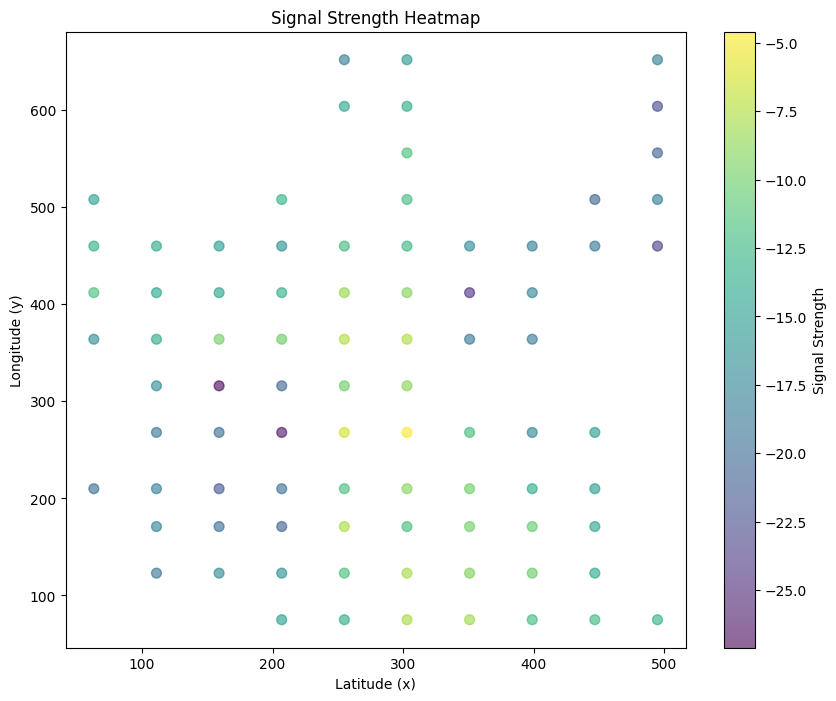

In [ ]:
# Step 9: Visualize data - Plot signal strength heatmap
plt.figure(figsize=(10, 8))
plt.scatter(data['Pixel_Latitude_X'], data['Pixel_Longitude_Y'], c=data['avg_signal_strength_dBm'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Signal Strength')
plt.xlabel('Latitude (x)')
plt.ylabel('Longitude (y)')
plt.title('Signal Strength Heatmap')
plt.show()


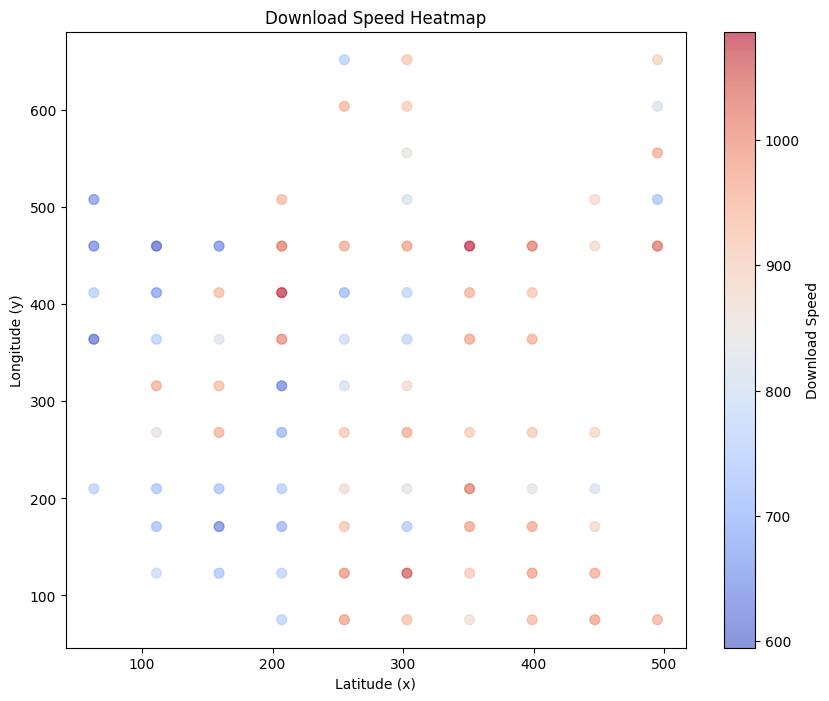

In [ ]:
# Visualize download speed heatmap
plt.figure(figsize=(10, 8))
plt.scatter(data['Pixel_Latitude_X'], data['Pixel_Longitude_Y'], c=data['avg_download_speed_Mbps'], cmap='coolwarm', s=50, alpha=0.6)
plt.colorbar(label='Download Speed')
plt.xlabel('Latitude (x)')
plt.ylabel('Longitude (y)')
plt.title('Download Speed Heatmap')
plt.show()

# **📊 Exploratory Data Analysis (EDA) for Processed Spatio-Temporal RSS Dataset**
## **1. Data Overview and Integrity Checks**
Concept:
Before modeling, ensure data quality by checking for missing values, duplicates, and basic statistics.

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Overall_aggregated_data.csv')

# Show the first few rows
df.head()


,Coordinate,Pixel_Latitude_X,Pixel_Longitude_Y,Network_Type,avg_signal_strength_dBm,avg_download_speed_Mbps,avg_transmitter_signal_strength_dBm,avg_transmitter_download_speed_Mbps
0,"111,123",111,123,Wi-Fi,-18.8,786.214288,-20.82,970.621
1,"111,171",111,171,Wi-Fi,-17.6,717.930458,-20.76,976.441
2,"111,210",111,210,Wi-Fi,-18.0,731.089554,-25.05,898.573
3,"159,123",159,123,Wi-Fi,-16.8,728.021518,-21.86,961.541
4,"159,171",159,171,Wi-Fi,-19.7,634.539157,-29.79,796.972


In [ ]:
# Check for missing values, data types, and duplicates
print("Missing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Summary statistics
df.describe(include='all')


Missing values per column:
 Coordinate                             0
Pixel_Latitude_X                       0
Pixel_Longitude_Y                      0
Network_Type                           0
avg_signal_strength_dBm                0
avg_download_speed_Mbps                0
avg_transmitter_signal_strength_dBm    0
avg_transmitter_download_speed_Mbps    0
dtype: int64

Data types:
 Coordinate                              object
Pixel_Latitude_X                         int64
Pixel_Longitude_Y                        int64
Network_Type                            object
avg_signal_strength_dBm                float64
avg_download_speed_Mbps                float64
avg_transmitter_signal_strength_dBm    float64
avg_transmitter_download_speed_Mbps    float64
dtype: object

Number of duplicate rows: 0


,Coordinate,Pixel_Latitude_X,Pixel_Longitude_Y,Network_Type,avg_signal_strength_dBm,avg_download_speed_Mbps,avg_transmitter_signal_strength_dBm,avg_transmitter_download_speed_Mbps
count,84,84.000000,84.000000,84,84.000000,84.000000,84.000000,84.000000
unique,84,NaN,NaN,1,NaN,NaN,NaN,NaN
top,"111,123",NaN,NaN,Wi-Fi,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,84,NaN,NaN,NaN,NaN
mean,NaN,278.428571,318.083333,NaN,-14.594048,860.632830,-25.167738,890.434722
std,NaN,123.896798,162.009609,NaN,4.769692,123.728269,3.344174,69.296572
min,NaN,63.000000,75.000000,NaN,-27.100000,594.849577,-30.310000,686.708323
25%,NaN,195.000000,171.000000,NaN,-18.000000,754.814149,-28.122500,829.679565
50%,NaN,279.000000,316.000000,NaN,-14.100000,881.542273,-25.055000,888.336000
75%,NaN,363.000000,460.000000,NaN,-11.500000,960.921170,-22.302500,943.477000


## **2. Spatial Distribution Analysis**
Concept:
Visualize how RSS varies across the physical layout. Heatmaps help identify coverage holes and spatial trends.

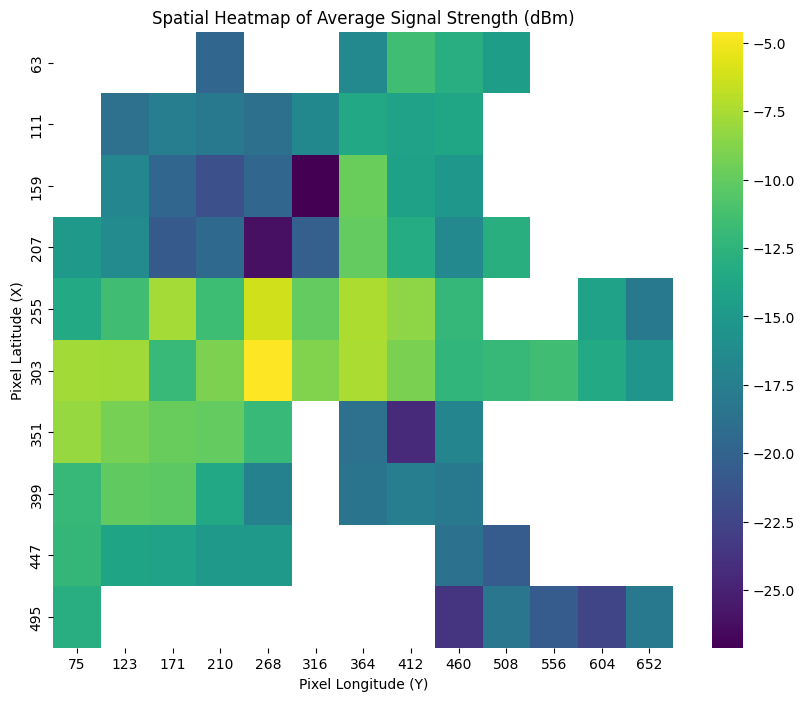

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of average spatial RSS
plt.figure(figsize=(10, 8))
pivot_rss = df.pivot_table(values='avg_signal_strength_dBm',
                           index='Pixel_Latitude_X', columns='Pixel_Longitude_Y')
sns.heatmap(pivot_rss, cmap='viridis', annot=False)
plt.title('Spatial Heatmap of Average Signal Strength (dBm)')
plt.xlabel('Pixel Longitude (Y)')
plt.ylabel('Pixel Latitude (X)')
plt.show()


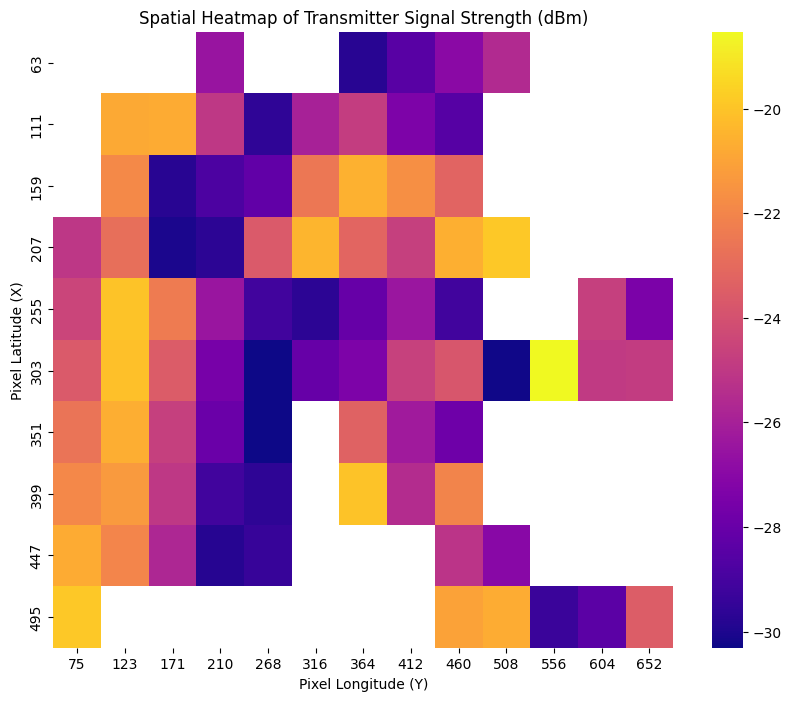

In [ ]:
# Heatmap of average transmitter RSS
plt.figure(figsize=(10, 8))
pivot_tx = df.pivot_table(values='avg_transmitter_signal_strength_dBm',
                          index='Pixel_Latitude_X', columns='Pixel_Longitude_Y')
sns.heatmap(pivot_tx, cmap='plasma', annot=False)
plt.title('Spatial Heatmap of Transmitter Signal Strength (dBm)')
plt.xlabel('Pixel Longitude (Y)')
plt.ylabel('Pixel Latitude (X)')
plt.show()


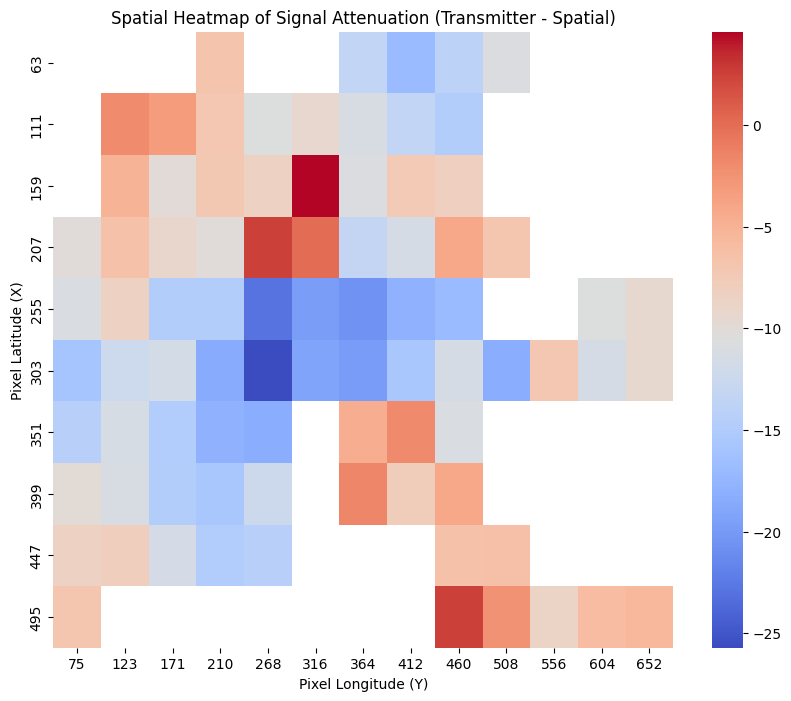

In [ ]:
# Heatmap of difference (attenuation)
plt.figure(figsize=(10, 8))
# Calculate the difference between the columns first and assign to a new column
df['attenuation'] = df['avg_transmitter_signal_strength_dBm'] - df['avg_signal_strength_dBm']

pivot_diff = df.pivot_table(
    # values=df['avg_transmitter_signal_strength_dBm'] - df['avg_signal_strength_dBm'],
    values='attenuation',
    index='Pixel_Latitude_X', columns='Pixel_Longitude_Y')
sns.heatmap(pivot_diff, cmap='coolwarm', annot=False)
plt.title('Spatial Heatmap of Signal Attenuation (Transmitter - Spatial)')
plt.xlabel('Pixel Longitude (Y)')
plt.ylabel('Pixel Latitude (X)')
plt.show()


## **3. Signal Strength Correlations**
Concept:
Understand the relationship between transmitter RSS and spatial RSS, and how these relate to download speed.

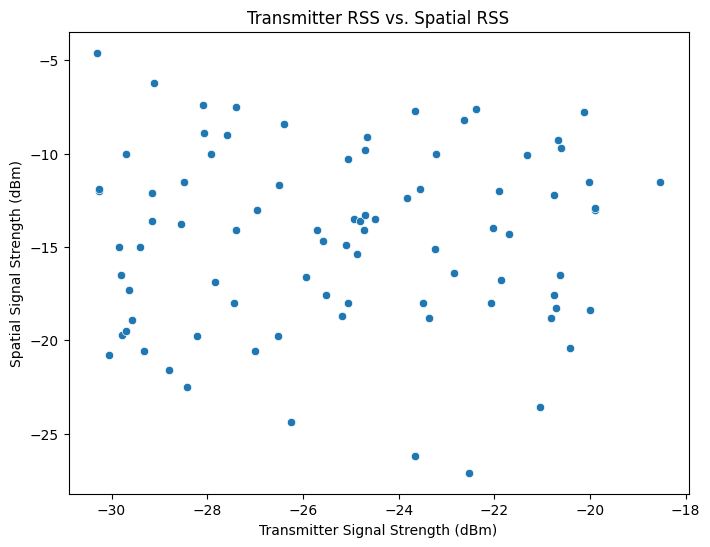

In [ ]:
# Scatter plot: Transmitter RSS vs. Spatial RSS
plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_transmitter_signal_strength_dBm', y='avg_signal_strength_dBm', data=df)
plt.title('Transmitter RSS vs. Spatial RSS')
plt.xlabel('Transmitter Signal Strength (dBm)')
plt.ylabel('Spatial Signal Strength (dBm)')
plt.show()


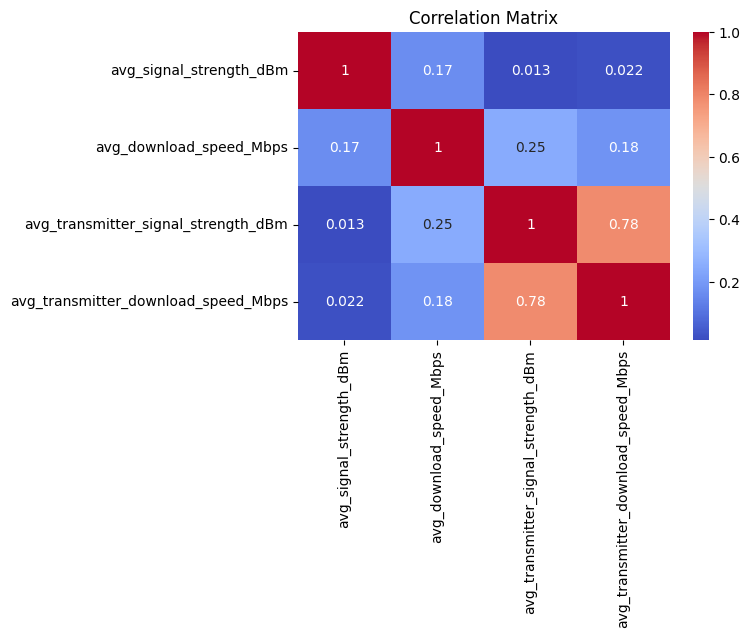

In [ ]:
# Correlation matrix
corr = df[['avg_signal_strength_dBm', 'avg_download_speed_Mbps',
           'avg_transmitter_signal_strength_dBm', 'avg_transmitter_download_speed_Mbps']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## **4. Download Speed vs Signal Strength**
Concept:
Assess how signal strength affects throughput, which is crucial for user experience.

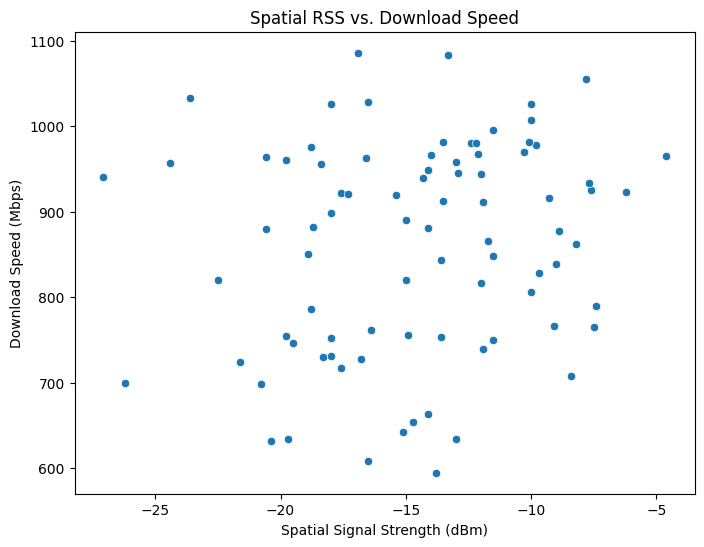

In [ ]:
# Scatter: Spatial RSS vs. Download Speed
plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_signal_strength_dBm', y='avg_download_speed_Mbps', data=df)
plt.title('Spatial RSS vs. Download Speed')
plt.xlabel('Spatial Signal Strength (dBm)')
plt.ylabel('Download Speed (Mbps)')
plt.show()


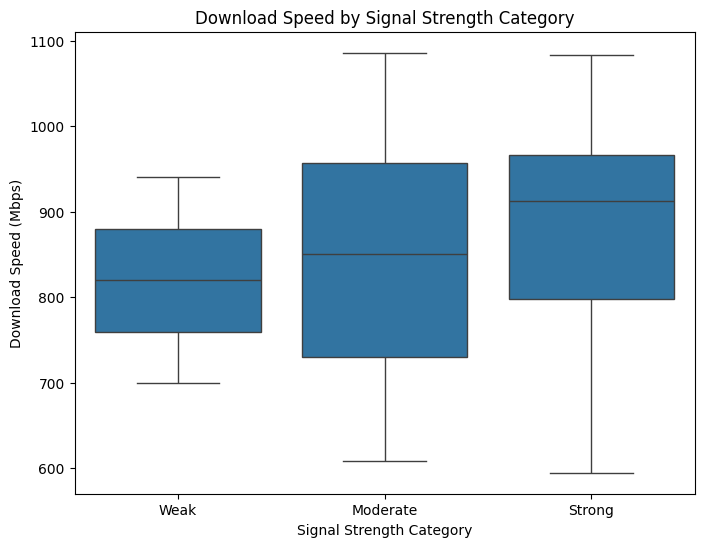

In [ ]:
# Boxplot: Download speed grouped by binned RSS
df['RSS_bin'] = pd.cut(df['avg_signal_strength_dBm'], bins=[-35, -25, -15, 0], labels=['Weak', 'Moderate', 'Strong'])
plt.figure(figsize=(8,6))
sns.boxplot(x='RSS_bin', y='avg_download_speed_Mbps', data=df)
plt.title('Download Speed by Signal Strength Category')
plt.xlabel('Signal Strength Category')
plt.ylabel('Download Speed (Mbps)')
plt.show()


## **5. Signal Strength Distribution**
Concept:
Visualize the spread and central tendency of RSS values to spot outliers and understand the environment.

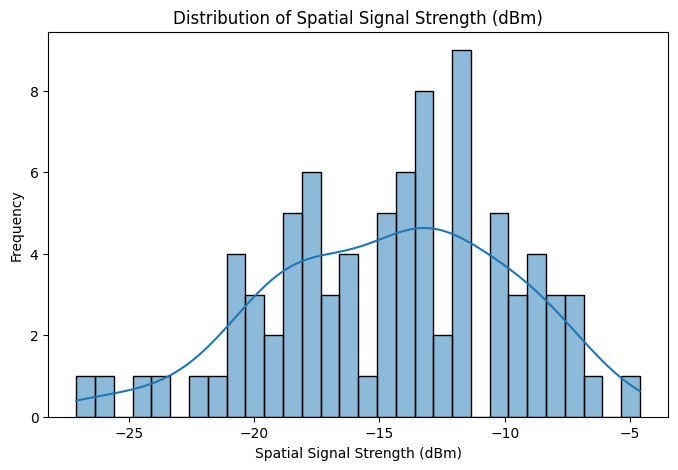

In [ ]:
# Histogram and KDE: Spatial RSS
plt.figure(figsize=(8,5))
sns.histplot(df['avg_signal_strength_dBm'], kde=True, bins=30)
plt.title('Distribution of Spatial Signal Strength (dBm)')
plt.xlabel('Spatial Signal Strength (dBm)')
plt.ylabel('Frequency')
plt.show()


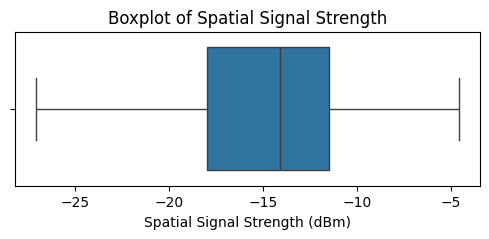

In [ ]:
# Boxplot: Spatial RSS
plt.figure(figsize=(6,2))
sns.boxplot(x='avg_signal_strength_dBm', data=df)
plt.title('Boxplot of Spatial Signal Strength')
plt.xlabel('Spatial Signal Strength (dBm)')
plt.show()


## **6. Alignment Validation: Transmitter vs. Spatial RSS**
Concept:
Check the mapping by visualizing the difference between transmitter and spatial RSS.

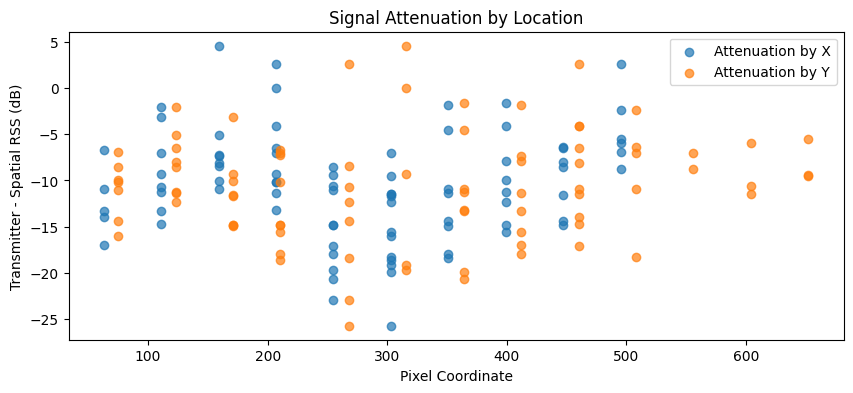

In [ ]:
# Scatter: Difference vs. Location
df['attenuation'] = df['avg_transmitter_signal_strength_dBm'] - df['avg_signal_strength_dBm']
plt.figure(figsize=(10,4))
plt.scatter(df['Pixel_Latitude_X'], df['attenuation'], alpha=0.7, label='Attenuation by X')
plt.scatter(df['Pixel_Longitude_Y'], df['attenuation'], alpha=0.7, label='Attenuation by Y')
plt.title('Signal Attenuation by Location')
plt.xlabel('Pixel Coordinate')
plt.ylabel('Transmitter - Spatial RSS (dB)')
plt.legend()
plt.show()


# **Data Visualization**

In [ ]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np


In [ ]:
# Step 2: Load the data from CSV
# 'processed_data.csv' has already been created with coordinate, latitude, longitude, avg_signal_strength, avg_download_speed
data = pd.read_csv('processed_data.csv')

print("Processed Data Preview:")
print(data.head())

Processed Data Preview:
  Coordinate  Pixel_Latitude_X  Pixel_Longitude_Y Network_Type  \
0    111,123               111                123        Wi-Fi   
1    111,171               111                171        Wi-Fi   
2    111,210               111                210        Wi-Fi   
3    111,268               111                268        Wi-Fi   
4    111,316               111                316        Wi-Fi   

   avg_signal_strength_dBm  avg_download_speed_Mbps  
0                    -18.8               786.214288  
1                    -17.6               717.930458  
2                    -18.0               731.089554  
3                    -18.9               851.166909  
4                    -16.6               962.604422  


In [ ]:
# The floor plan image file name is 'floor_plan.png'
floor_plan = cv2.imread('floor_plan.png')
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib compatibility

# Get the dimensions of the image
img_height, img_width, _ = floor_plan.shape
print(floor_plan.shape)

(705, 561, 3)


In [ ]:
# Step 4: Create pivot tables for signal strength and download speed based on coordinates
# Note: Ensure latitude and longitude correspond to image coordinates (pixels)
signal_pivot = np.random.rand(img_width, img_height)
signal_pivot = data.pivot_table(index='Pixel_Longitude_Y', columns='Pixel_Latitude_X', values='avg_signal_strength_dBm')
download_pivot = data.pivot_table(index='Pixel_Longitude_Y', columns='Pixel_Latitude_X', values='avg_download_speed_Mbps')
signal_pivot.shape


(13, 10)

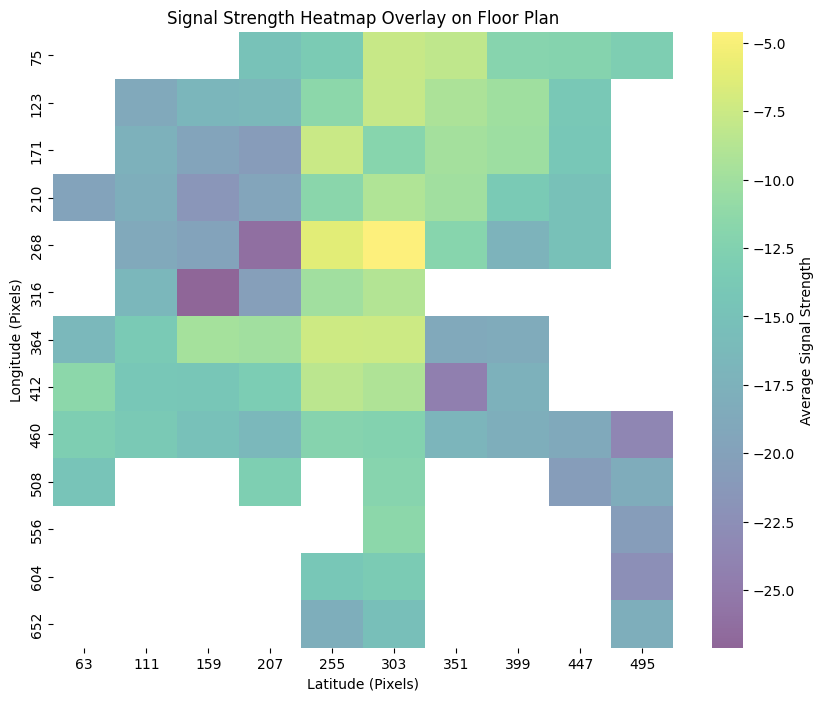

In [ ]:
# Step 5: Plot the heatmap on the floor plan image
plt.figure(figsize=(10, 8))

# Define the boundaries of the room within the floor plan
# room_x_min, room_x_max = 220, img_width
# room_y_min, room_y_max = 435, img_height


# Display the floor plan image
# plt.imshow(floor_plan, extent=[0, img_width, img_height, 0])  # extent aligns the heatmap with the image

# Define an inset axes for the room's heatmap
# room_ax = plt.gca().inset_axes(
#     [room_x_min / floor_plan.shape[1],  # x-position of inset as fraction
#      1 - room_y_max / floor_plan.shape[0],  # y-position of inset as fraction (invert y-axis)
#      (room_x_max - room_x_min) / floor_plan.shape[1],  # width as fraction
#      (room_y_max - room_y_min) / floor_plan.shape[0]  # height as fraction
#     ]
# )

# Overlay the signal strength heatmap on the floor plan
sns.heatmap(signal_pivot, cmap='viridis', alpha=0.6, zorder=2, # ax=room_ax
            cbar_kws={'label': 'Average Signal Strength'},  # Color bar label
            xticklabels=True, yticklabels=True)  # Hides ticks for a cleaner overlay

# room_ax.set_xlim(room_x_min, room_x_max)
# room_ax.set_ylim(room_y_max, room_y_min)
# room_ax.axis('off')  # Hide axis for the inset


# Display the plot
plt.title('Signal Strength Heatmap Overlay on Floor Plan')
plt.ylabel('Longitude (Pixels)')
plt.xlabel('Latitude (Pixels)')
plt.show()

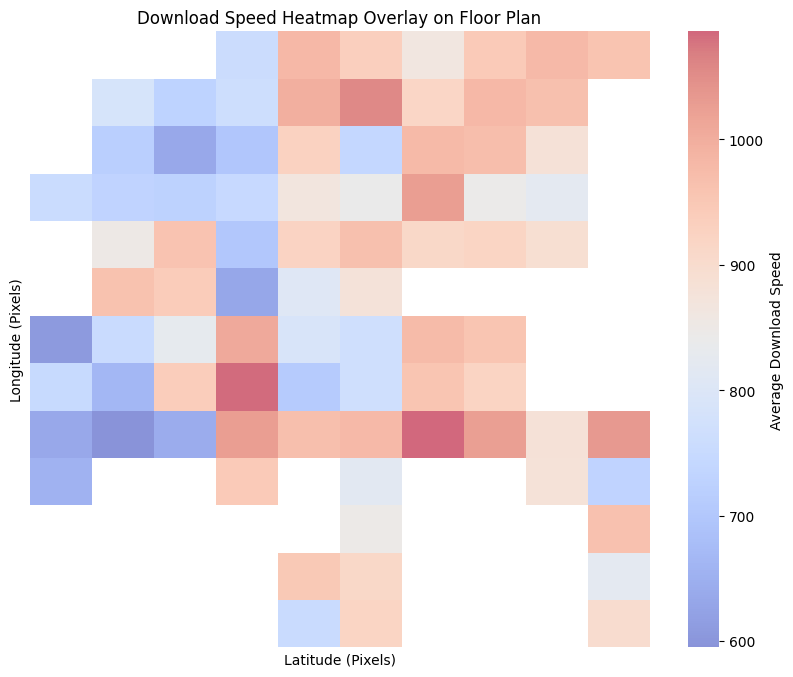

In [ ]:
# Step 11: Plot the download speed heatmap for the room
plt.figure(figsize=(10, 8))
# plt.imshow(floor_plan, extent=[0, img_width, img_height, 0])

sns.heatmap(download_pivot, cmap='coolwarm', alpha=0.6, zorder=2,
            cbar_kws={'label': 'Average Download Speed'},
            xticklabels=False, yticklabels=False)  # Match extent to room boundaries

plt.title('Download Speed Heatmap Overlay on Floor Plan')
plt.ylabel('Longitude (Pixels)')
plt.xlabel('Latitude (Pixels)')
plt.show()

# **CNN Input Images Generation: LAMS Algorithm**
**TR Seperation Calculated as well...**

In [ ]:
# Step 1: Import libraries and set up environment
import numpy as np
import pandas as pd
import cv2
import os
from math import sqrt

In [ ]:
# Step 2: Set up folders for saving images
os.makedirs("CNN Input Images", exist_ok=True)
os.makedirs("Lams Scan Images", exist_ok=True)


In [ ]:
# Step 3: Updated LAMS Algorithm function
def lams_algorithm(floor_plan, ap_coords, receiver_coords, w, n):
    # Initialize the LAMS image and a copy of the floor plan to draw Scan lines on
    lams_image = np.zeros((n, w), dtype=np.uint8)
    floor_plan_with_lines = floor_plan.copy()

    # Define coordinates for the transmitter (AP) and receiver
    x1, y1 = ap_coords
    x2, y2 = receiver_coords

    # Generate points along the line from AP to receiver
    line_points = np.linspace([x1, y1], [x2, y2], n)

    for i, (x_mid, y_mid) in enumerate(line_points):
        # Calculate perpendicular direction for the scan line
        dx, dy = x2 - x1, y2 - y1
        norm = sqrt(dx**2 + dy**2)
        dx_perp, dy_perp = -dy / norm, dx / norm

        # Calculate start and end points of the scan line
        x_start = int(x_mid - (w // 2) * dx_perp)
        y_start = int(y_mid - (w // 2) * dy_perp)
        x_end = int(x_mid + (w // 2) * dx_perp)
        y_end = int(y_mid + (w // 2) * dy_perp)

        # Sample the scan line and add values to the LAMS image
        scan_line = np.linspace([x_start, y_start], [x_end, y_end], w)
        scan_values = [
            floor_plan[int(y), int(x)] if 0 <= x < floor_plan.shape[1] and 0 <= y < floor_plan.shape[0] else 0
            for x, y in scan_line
        ]
        lams_image[i, :] = scan_values

        # Draw the scan line on the floor plan with lines
        cv2.line(floor_plan_with_lines, (x_start, y_start), (x_end, y_end), (20,0,0), 1)

    return lams_image, floor_plan_with_lines


In [ ]:
# Step 4: Load processed_data.csv and extract receiver coordinates
data = pd.read_csv('processed_data.csv')
receiver_coords = list(zip(data['Pixel_Latitude_X'], data['Pixel_Longitude_Y']))
ap_coords = (312, 350)  # Fixed AP (Transmitter) coordinates
w, n = 100, 100  # Width and number of scan lines
floor_plan = cv2.imread('floor_plan.png', cv2.IMREAD_GRAYSCALE)
len(receiver_coords)

84

In [ ]:
# Step 5: Generate and save images
tr_separation = []

for (lat, lon) in receiver_coords:
    receiver = (lat, lon)

    # Call the updated function to get both images
    lams_image, floor_plan_with_lines = lams_algorithm(floor_plan, ap_coords, receiver, w, n)

    # Save the LAMS image
    lams_filename = f"CNN Input Images/{lat}_{lon}.png"
    cv2.imwrite(lams_filename, lams_image)

    # Save the floor plan with scan lines
    scan_lines_filename = f"Lams Scan Images/{lat}_{lon}.png"
    cv2.imwrite(scan_lines_filename, floor_plan_with_lines)

    # Calculate and store TR separation
    tr_sep = sqrt((ap_coords[0] - lat) ** 2 + (ap_coords[1] - lon) ** 2)
    tr_separation.append(tr_sep)


In [ ]:
# Step 6: Add TR Separation to CSV and Save
data['TR_separation'] = tr_separation
data.to_csv('processed_data_with_tr_separation.csv', index=False)

print("LAMS images and floor plans with scan lines have been saved.")
print("TR separation added to the CSV file successfully.")


LAMS images and floor plans with scan lines have been saved.
TR separation added to the CSV file successfully.


# Model Training

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt


In [ ]:
# 1. Load CSV file
data = pd.read_csv("processed_data_with_tr_separation.csv")
data.head()

,Coordinate,Pixel_Latitude_X,Pixel_Longitude_Y,Network_Type,avg_signal_strength_dBm,avg_download_speed_Mbps,TR_separation
0,"111,123",111,123,Wi-Fi,-18.8,786.214288,303.199604
1,"111,171",111,171,Wi-Fi,-17.6,717.930458,269.150516
2,"111,210",111,210,Wi-Fi,-18.0,731.089554,244.951016
3,"111,268",111,268,Wi-Fi,-18.9,851.166909,217.082933
4,"111,316",111,316,Wi-Fi,-16.6,962.604422,203.855341


In [ ]:
# 2. Load images and corresponding TR separation and RSS values
input_images = []
tr_separation = []
rss_labels = []

image_folder = "CNN Input Images"
for _, row in data.iterrows():
    lat, lon = row["Pixel_Latitude_X"], row["Pixel_Longitude_Y"]
    image_path = os.path.join(image_folder, f"{lat}_{lon}.png")

    # Read image and resize if needed
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        input_images.append(image)
        tr_separation.append(row["TR_separation"])
        rss_labels.append(row["avg_signal_strength_dBm"] + 100)  # Shift RSS by 100

# Convert to NumPy arrays
input_images = np.array(input_images) / 255.0  # Normalize images
input_images = np.expand_dims(input_images, axis=-1)  # Add channel dimension
tr_separation = np.array(tr_separation).reshape(-1, 1)  # Reshape as (N, 1)
rss_labels = np.array(rss_labels)

In [ ]:
# 3. Train/Test Split
X_train, X_test, tr_train, tr_test, y_train, y_test = train_test_split(
    input_images, tr_separation, rss_labels, test_size=0.1, random_state=42
)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, images, tr_sep, labels, batch_size):
        """
        Initialize the data generator.
        :param images: Input images (numpy array).
        :param tr_sep: TR separation values (numpy array).
        :param labels: Target labels (numpy array).
        :param batch_size: Number of samples per batch.
        """
        self.images = images
        self.tr_sep = tr_sep
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Retrieve a batch of data.
        :param index: Index of the batch.
        :return: Tuple of inputs ([images, tr_sep]) and labels.
        """
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_tr_sep = self.tr_sep[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        return [batch_images, batch_tr_sep], batch_labels

    def on_epoch_end(self):
        """
        Optional callback to shuffle data at the end of each epoch.
        """
        indices = np.arange(len(self.images))
        np.random.shuffle(indices)
        self.images = self.images[indices]
        self.tr_sep = self.tr_sep[indices]
        self.labels = self.labels[indices]

def data_generator(images, tr_sep, labels, batch_size):
    """
    A generator function that yields TensorFlow tensors with correct structure.
    """
    generator = DataGenerator(images, tr_sep, labels, batch_size)
    for i in range(len(generator)):
        batch_inputs, batch_labels = generator[i]
        yield ((tf.convert_to_tensor(batch_inputs[0], dtype=tf.float32),  # images
                tf.convert_to_tensor(batch_inputs[1], dtype=tf.float32)),  # tr_sep
               tf.convert_to_tensor(batch_labels, dtype=tf.float32))  # labels

In [ ]:
# Define the output signature
output_signature = (
    (tf.TensorSpec(shape=(None,) + X_train.shape[1:], dtype=tf.float32),  # Image batch
     tf.TensorSpec(shape=(None,) + tr_train.shape[1:], dtype=tf.float32)),  # TR separation batch
    tf.TensorSpec(shape=(None,), dtype=tf.float32)  # Labels batch
)

# Create train and test datasets
batch_size = 5

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, tr_train, y_train, batch_size),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, tr_test, y_test, batch_size),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)


In [ ]:
# # 5. Define the CNN Model with Distance Neuron
# def create_cnn_with_distance(input_shape=(100, 100, 1)):
#     # Image branch
#     image_input = tf.keras.Input(shape=input_shape, name="image_input")
#     x = layers.Conv2D(3, (6, 6), strides=1, padding="VALID", activation="relu")(image_input)
#     x = layers.Conv2D(6, (3, 3), strides=1, padding="VALID", activation="relu")(x)
#     x = layers.Conv2D(3, (3, 3), strides=1, padding="SAME", activation="relu")(x)
#     x = layers.Conv2D(3, (3, 3), strides=1, padding="SAME", activation="relu")(x)
#     x = layers.Conv2D(2, (3, 3), strides=1, padding="VALID", activation="relu")(x)
#     x = layers.Flatten()(x)

#     # Distance neuron input
#     distance_input = tf.keras.Input(shape=(1,), name="distance_input")

#     # Concatenate image features and distance neuron
#     combined = tf.keras.layers.Concatenate()([x, distance_input])

#     # Fully connected layers
#     fc = layers.Dense(7, activation="relu")(combined)
#     fc = layers.Dense(3, activation="relu")(fc)

#     # Output layer
#     output = layers.Dense(1, activation="linear", name="rss_output")(fc)

#     # Create model
#     model = tf.keras.Model(inputs=[image_input, distance_input], outputs=output)

#     # Compile model
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-6),
#         loss="mean_squared_error",
#         metrics=[tf.keras.metrics.RootMeanSquaredError()]
#     )

#     return model

# model = create_cnn_with_distance(input_shape=(100, 100, 1))  # Assuming your input image shape


In [ ]:
def create_cnn_with_distance(input_shape=(100, 100, 1)):  # Adjusting to 3 input channels
    # Image branch
    image_input = tf.keras.Input(shape=input_shape, name="image_input")

    # Convolutional layer C1: Input channels = 3, Output channels = 6, Kernel size = 4x4, Stride = 3
    x = layers.Conv2D(3, (6, 6), strides=1, padding="VALID", activation="relu")(image_input)

    x = layers.Conv2D(6, (4, 4), strides=3, padding="VALID", activation="relu")(x)
    # Convolutional layer C2: Input channels = 6, Output channels = 3, Kernel size = 3x3, Stride = 2
    x = layers.Conv2D(3, (3, 3), strides=2, padding="VALID", activation="relu")(x)

    # Convolutional layer Cmj: Input channels = 3, Output channels = 3, Kernel size = 2x2, Stride = 1
    x = layers.Conv2D(3, (2, 2), strides=1, padding="SAME", activation="relu")(x)
    x = layers.Conv2D(3, (2, 2), strides=1, padding="SAME", activation="relu")(x)

    # Convolutional layer Cf: Input channels = 3, Output channels = 2, Kernel size = 2x2, Stride = 2
    x = layers.Conv2D(2, (2, 2), strides=2, padding="VALID", activation="relu")(x)

    # Flatten the output
    x = layers.Flatten()(x)

    # Distance neuron input
    distance_input = tf.keras.Input(shape=(1,), name="distance_input")

    # Concatenate image features and distance neuron
    combined = tf.keras.layers.Concatenate()([x, distance_input])

    # Fully connected layers
    fc = layers.Dense(7, activation="relu")(combined)
    fc = layers.Dense(3, activation="relu")(fc)

    # Output layer
    output = layers.Dense(1, activation="linear", name="rss_output")(fc)

    # Create model
    model = tf.keras.Model(inputs=[image_input, distance_input], outputs=output)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-6),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

# Instantiate the model
model = create_cnn_with_distance(input_shape=(100, 100, 1))  # Adjusting input shape for 3 channels


In [ ]:
# 6. Train the Model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,  # Adjust epochs based on performance
    verbose=1
)

Epoch 1/50
     15/Unknown 6s 4ms/step - loss: 7419.5039 - root_mean_squared_error: 86.1341

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 7418.2627 - root_mean_squared_error: 86.1271 - val_loss: 6612.6519 - val_root_mean_squared_error: 81.3182
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7415.6836 - root_mean_squared_error: 86.1121 - val_loss: 6610.2163 - val_root_mean_squared_error: 81.3032
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7413.1045 - root_mean_squared_error: 86.0971 - val_loss: 6607.7832 - val_root_mean_squared_error: 81.2883
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7410.5269 - root_mean_squared_error: 86.0822 - val_loss: 6605.3496 - val_root_mean_squared_error: 81.2733
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7407.9497 - root_mean_squared_error: 86.0672 - val_loss: 6602.9170 - val_root_mean_squared_error: 81.2583
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7405.3730 - root_mean_squared_error: 86.0522 - val_loss: 6600.4854 - val_root_mean_squared_error: 81.2434
Epoch 7/50
15/15 ━━━━━━━━━

In [ ]:
# 7. Evaluate the Model
loss, rmse = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test RMSE: {rmse}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6511.7627 - root_mean_squared_error: 80.6953
Test Loss: 6493.99267578125, Test RMSE: 80.58531188964844


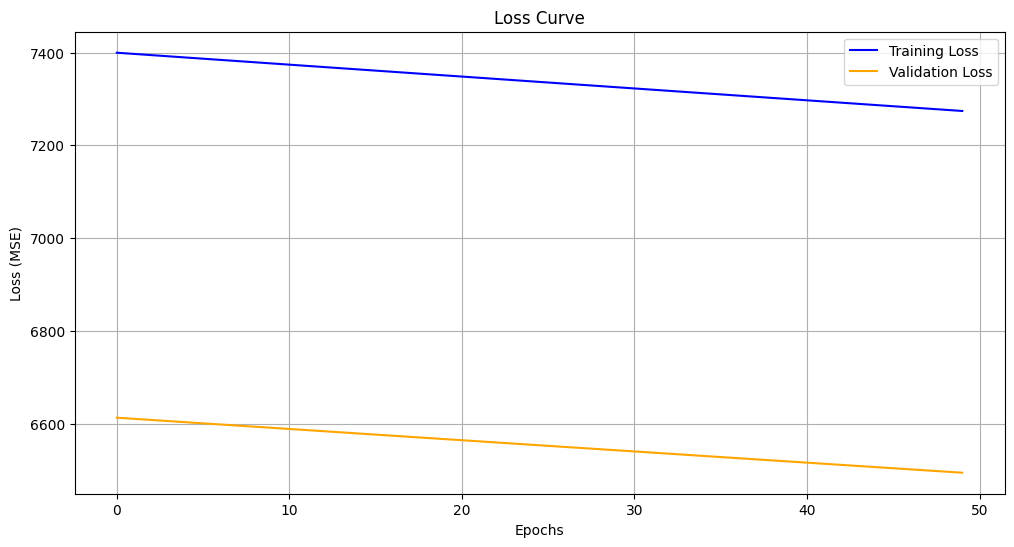

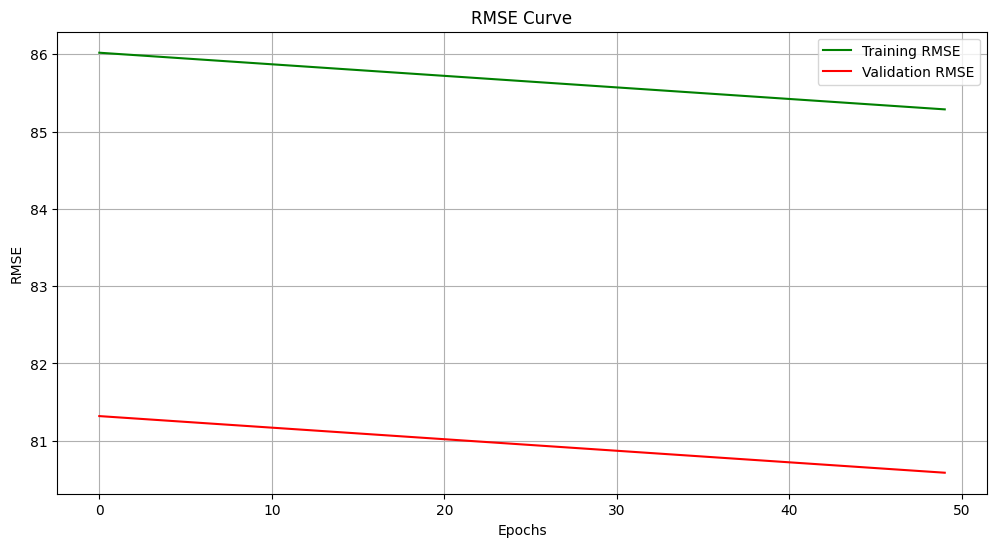

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE Curve
plt.figure(figsize=(12, 6))
plt.plot(history.history["root_mean_squared_error"], label="Training RMSE", color="green")
plt.plot(history.history["val_root_mean_squared_error"], label="Validation RMSE", color="red")
plt.title("RMSE Curve")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Step 1: Load test data (coordinates, TR separation, and image paths)
test_data = pd.read_csv('processed_data_with_tr_separation.csv')
image_folder = "CNN Input Images"  # Folder where CNN input images are saved

# Prepare empty lists for predictions, coordinates, and TR separation
predicted_rss = []
coordinates = []
tr_separation_list = []

# Step 2: Loop through each coordinate and make predictions
for idx, row in test_data.iterrows():
    # Get coordinates and TR separation
    lat, lon = row['Pixel_Latitude_X'], row['Pixel_Longitude_Y']
    tr_separation = row['TR_separation']  # Ensure this column exists in your CSV
    coordinates.append((lat, lon))
    tr_separation_list.append(tr_separation)  # Save TR separation for later use

    # Load the corresponding image
    image_path = os.path.join(image_folder, f"{lat}_{lon}.png")
    if not os.path.exists(image_path):
        print(f"Image not found for coordinates: ({lat}, {lon})")
        continue

    # Preprocess the image for the CNN model
    img = load_img(image_path, target_size=(100, 100), color_mode='grayscale')  # Ensure correct dimensions
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Prepare TR separation input for the model
    tr_separation_array = np.array([[tr_separation]], dtype=np.float32)  # Reshape as (batch_size, 1)

    # Step 3: Make predictions using the trained model
    rss_pred = model.predict([img_array, tr_separation_array], verbose=0)  # Pass both inputs
    predicted_rss.append(rss_pred[0][0] - 100)  # Extract the single predicted value (RSS)

# Step 4: Create a DataFrame with coordinates, predictions, and TR separation
results_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])
results_df['TR_separation'] = tr_separation_list
results_df['Predicted_RSS'] = predicted_rss

# Save the results to a CSV file
results_df.to_csv('predicted_rss_with_tr_separation.csv', index=False)
print("Predicted RSS values saved to 'predicted_rss_with_tr_separation.csv'.")

# Optional: Display a preview of the results
print(results_df.head())



Predicted RSS values saved to 'predicted_rss_with_tr_separation.csv'.
   Latitude  Longitude  TR_separation  Predicted_RSS
0       111        123     303.199604     -99.250794
1       111        171     269.150516     -99.250794
2       111        210     244.951016     -99.250794
3       111        268     217.082933     -99.250794
4       111        316     203.855341     -99.250794


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the floor plan
floor_plan = cv2.imread('floor_plan.png', cv2.IMREAD_GRAYSCALE)
floor_plan_rgb = cv2.cvtColor(floor_plan, cv2.COLOR_GRAY2RGB)  # Convert to RGB for better visualization

# Step 2: Load the predicted values
# Ensure your DataFrame has 'x', 'y', and 'predicted_rss' columns
predicted_data = pd.read_csv('predicted_rss_with_tr_separation.csv')  # Replace with your file

# Step 3: Create a blank heatmap matrix matching the floor plan size
heatmap_matrix = np.zeros_like(floor_plan, dtype=float)

# Step 4: Populate the matrix with predicted values
for _, row in predicted_data.iterrows():
    x, y, predicted_rss = int(row['Latitude']), int(row['Longitude']), row['Predicted_RSS']
    if 0 <= x < heatmap_matrix.shape[1] and 0 <= y < heatmap_matrix.shape[0]:
        heatmap_matrix[y, x] = predicted_rss  # Note: (y, x) for image coordinates

# Step 5: Smooth the heatmap matrix (optional for better visualization)
# smoothed_heatmap = cv2.GaussianBlur(heatmap_matrix, (5, 5), 0)

# # Step 6: Plot the heatmap overlaid on the floor plan
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_matrix,
#             cmap='coolwarm',
#             alpha=0.5,  # Transparency for overlay
#             cbar=True,
#             zorder=2)  # Overlay heatmap
# plt.imshow(floor_plan, cmap='gray', zorder=1)  # Background floor plan
# plt.axis('off')
# plt.title('Predicted RSS Heatmap Overlaid on Floor Plan', fontsize=16)
# plt.show()


In [ ]:
# Get the dimensions of the image
img_height, img_width = floor_plan.shape
# Step 4: Create pivot tables for signal strength and download speed based on coordinates
# Note: Ensure latitude and longitude correspond to image coordinates (pixels)
signal_pivot = np.random.rand(img_width, img_height)
signal_pivot = predicted_data.pivot_table(index='Longitude', columns='Latitude', values='Predicted_RSS')
# download_pivot = predicted_datadata.pivot_table(index='Pixel_Longitude_Y', columns='Pixel_Latitude_X', values='avg_download_speed_Mbps')
signal_pivot.shape


(13, 10)

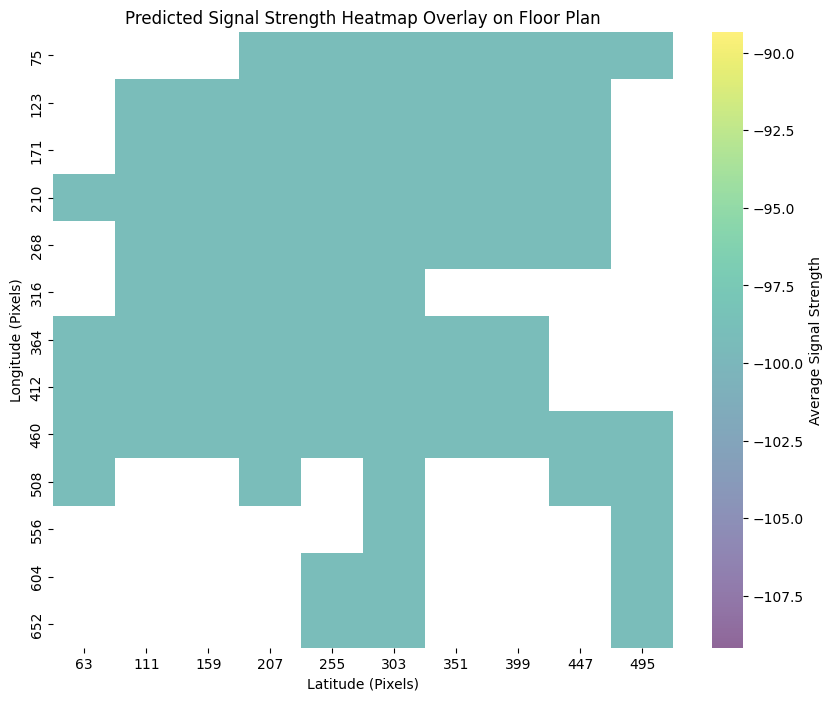

In [ ]:
# Step 5: Plot the heatmap on the floor plan image
plt.figure(figsize=(10, 8))

# Define the boundaries of the room within the floor plan
# room_x_min, room_x_max = 220, img_width
# room_y_min, room_y_max = 435, img_height


# Display the floor plan image
# plt.imshow(floor_plan, extent=[0, img_width, img_height, 0])  # extent aligns the heatmap with the image

# Define an inset axes for the room's heatmap
# room_ax = plt.gca().inset_axes(
#     [room_x_min / floor_plan.shape[1],  # x-position of inset as fraction
#      1 - room_y_max / floor_plan.shape[0],  # y-position of inset as fraction (invert y-axis)
#      (room_x_max - room_x_min) / floor_plan.shape[1],  # width as fraction
#      (room_y_max - room_y_min) / floor_plan.shape[0]  # height as fraction
#     ]
# )

# Overlay the signal strength heatmap on the floor plan
sns.heatmap(signal_pivot, cmap='viridis', alpha=0.6, zorder=2, # ax=room_ax
            cbar_kws={'label': 'Average Signal Strength'},  # Color bar label
            xticklabels=True, yticklabels=True)  # Hides ticks for a cleaner overlay

# room_ax.set_xlim(room_x_min, room_x_max)
# room_ax.set_ylim(room_y_max, room_y_min)
# room_ax.axis('off')  # Hide axis for the inset


# Display the plot
plt.title('Predicted Signal Strength Heatmap Overlay on Floor Plan')
plt.ylabel('Longitude (Pixels)')
plt.xlabel('Latitude (Pixels)')
plt.show()

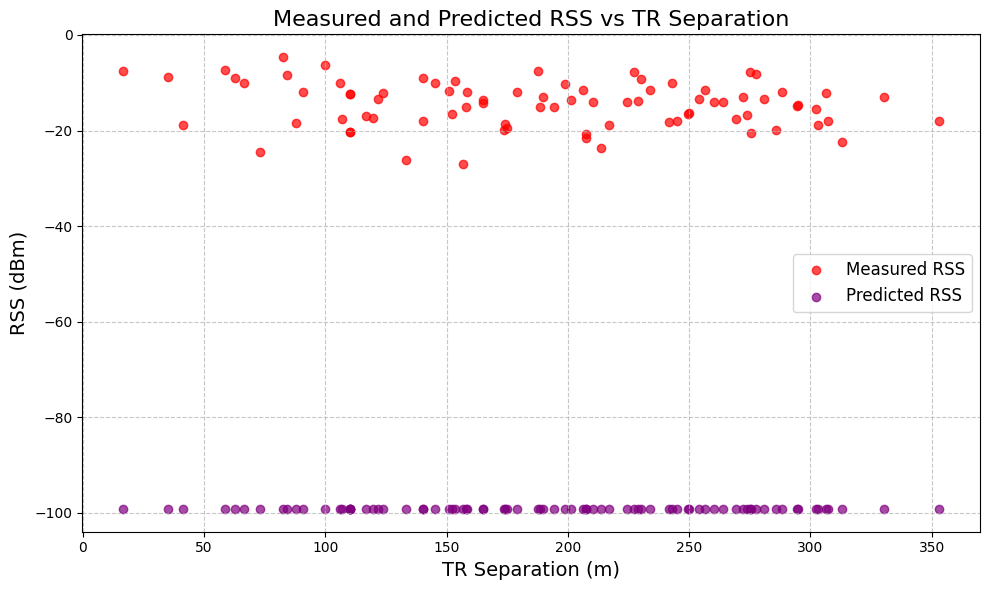

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the measured and predicted data
measured_data = pd.read_csv('processed_data_with_tr_separation.csv')  # Replace with your file
predicted_data = pd.read_csv('predicted_rss_with_tr_separation.csv')  # Replace with your file

# Merge the data on TR_separation and Type
data = pd.merge(measured_data, predicted_data, on=['TR_separation'])
data.head()

# Separate LoS and NLoS data
# los_data = data[data['Type'] == 'LoS']
# nlos_data = data[data['Type'] == 'NLoS']

# Define a curve fitting function (exponential decay as an example)
def rss_curve(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit curves for LoS and NLoS
# params_measured, _ = curve_fit(rss_curve, data['TR_separation'], data['avg_signal_strength_dBm'])
# params_predicted, _ = curve_fit(rss_curve, data['TR_separation'], data['Predicted_RSS'])
# nlos_params_measured, _ = curve_fit(rss_curve, nlos_data['TR_separation'], nlos_data['Measured_RSS'])
# nlos_params_predicted, _ = curve_fit(rss_curve, nlos_data['TR_separation'], nlos_data['Predicted_RSS'])

# Generate x values for smooth curves
x_vals = np.linspace(0, max(data['TR_separation']), 500)

# Generate curve fits
# curve_measured = rss_curve(x_vals, *params_measured)
# curve_predicted = rss_curve(x_vals, *params_predicted)
# nlos_curve_measured = rss_curve(x_vals, *nlos_params_measured)
# nlos_curve_predicted = rss_curve(x_vals, *nlos_params_predicted)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plots
plt.scatter(data['TR_separation'], data['avg_signal_strength_dBm'], color='red', label='Measured RSS', alpha=0.7)
plt.scatter(data['TR_separation'], data['Predicted_RSS'], color='purple', label='Predicted RSS', alpha=0.7)
# plt.scatter(nlos_data['TR_separation'], nlos_data['Measured_RSS'], color='blue', label='NLoS: Measured RSS', alpha=0.7)
# plt.scatter(nlos_data['TR_separation'], nlos_data['Predicted_RSS'], color='cyan', label='NLoS: Predicted RSS', alpha=0.7)

# Curve fits
# plt.plot(x_vals, curve_measured, color='red', linestyle='-', linewidth=2, label='Curve Fit of Measured RSS')
# plt.plot(x_vals, curve_predicted, color='purple', linestyle='--', linewidth=2, label='Curve Fit of Predicted RSS')
# plt.plot(x_vals, nlos_curve_measured, color='blue', linestyle='-', linewidth=2, label='NLoS: Curve Fit of Measured RSS')
# plt.plot(x_vals, nlos_curve_predicted, color='cyan', linestyle='--', linewidth=2, label='NLoS: Curve Fit of Predicted RSS')

# Customize plot
plt.title('Measured and Predicted RSS vs TR Separation', fontsize=16)
plt.xlabel('TR Separation (m)', fontsize=14)
plt.ylabel('RSS (dBm)', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()


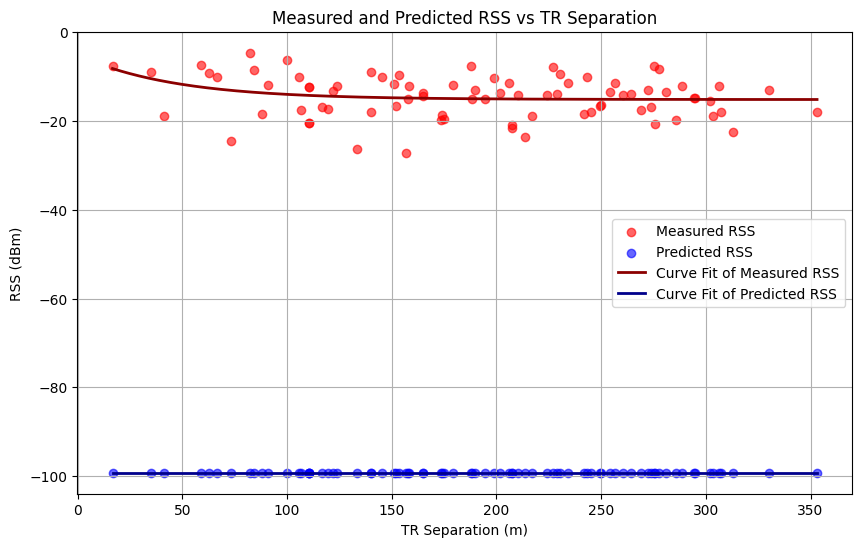

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define a robust RSS curve function
def rss_curve(x, a, b, c):
    return c + a * np.exp(-b * np.clip(x, 0, np.inf))  # Clamping x to avoid extreme values

# Clamp data to avoid infinite or NaN values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Add reasonable initial guesses and parameter bounds
initial_guess = [1, 1, -50]
bounds = ([0, 0, -200], [10, 10, 0])

# Fit measured data
params_measured, _ = curve_fit(
    rss_curve,
    data['TR_separation'],
    data['avg_signal_strength_dBm'],
    p0=initial_guess,
    bounds=bounds
)

# Fit predicted data
params_predicted, _ = curve_fit(
    rss_curve,
    data['TR_separation'],
    data['Predicted_RSS'],
    p0=initial_guess,
    bounds=bounds
)

# Generate predictions for plotting
x_vals = np.linspace(data['TR_separation'].min(), data['TR_separation'].max(), 500)
y_measured = rss_curve(x_vals, *params_measured)
y_predicted = rss_curve(x_vals, *params_predicted)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(data['TR_separation'], data['avg_signal_strength_dBm'], color='red', label='Measured RSS', alpha=0.6)
plt.scatter(data['TR_separation'], data['Predicted_RSS'], color='blue', label='Predicted RSS', alpha=0.6)
plt.plot(x_vals, y_measured, color='darkred', label='Curve Fit of Measured RSS', linewidth=2)
plt.plot(x_vals, y_predicted, color='darkblue', label='Curve Fit of Predicted RSS', linewidth=2)
plt.xlabel('TR Separation (m)')
plt.ylabel('RSS (dBm)')
plt.title('Measured and Predicted RSS vs TR Separation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("/content/signal_strength_prediction_model.h5")

Data Preview:
             Timestamp           Download Speed  Download Speed (Additional)  \
0   2024-11-27 19:9:21   533.5240930944057 Mbps                          NaN   
1  2024-11-27 19:11:21  1030.9992609797298 Mbps                          NaN   
2  2024-11-27 19:13:21   965.7461431962025 Mbps                          NaN   
3  2024-11-27 19:15:21   876.9419001436783 Mbps                          NaN   
4  2024-11-27 19:17:21    820.365003360215 Mbps                          NaN   

  Signal Strength  Signal Strength (Additional) Network Type Device Status  \
0       -14.0 dBm                           NaN        Wi-Fi       Unknown   
1       -16.0 dBm                           NaN        Wi-Fi       Unknown   
2       -15.0 dBm                           NaN        Wi-Fi       Unknown   
3       -15.0 dBm                           NaN        Wi-Fi       Unknown   
4       -15.0 dBm                           NaN        Wi-Fi       Unknown   

   Latitude  Longitude  Predicted_Si

<ipython-input-46-8b052da69962>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace("Unknown", np.nan, inplace=True)


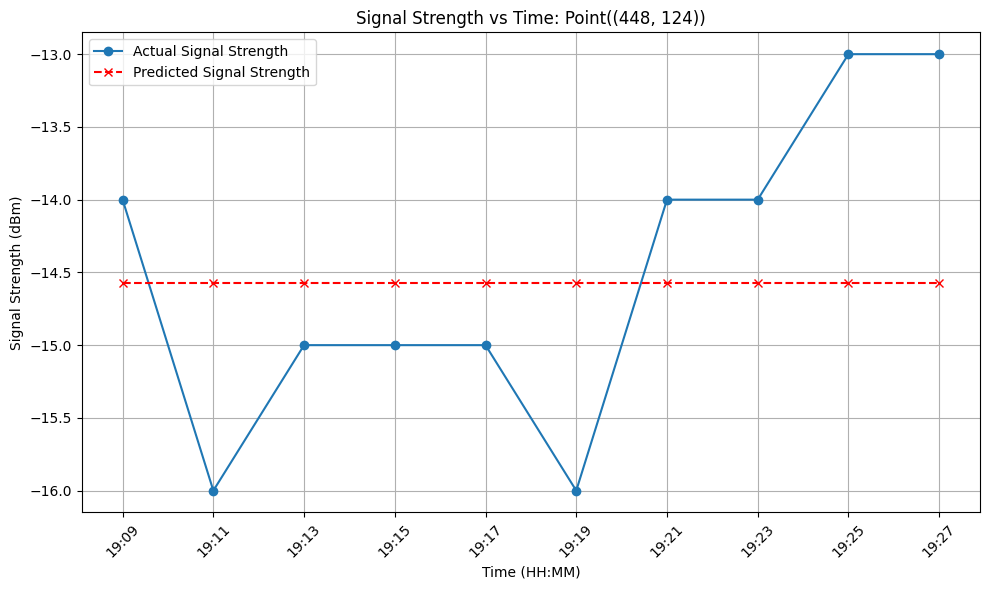

Data Preview:
             Timestamp           Download Speed  Download Speed (Additional)  \
0  2024-11-27 20:17:32  1045.1225385273974 Mbps                          NaN   
1  2024-11-27 20:19:32   1121.969784007353 Mbps                          NaN   
2  2024-11-27 20:21:32   978.1275040064103 Mbps                          NaN   
3  2024-11-27 20:22:32  1089.9135044642856 Mbps                          NaN   
4  2024-11-27 20:23:32   811.6377160904256 Mbps                          NaN   

  Signal Strength  Signal Strength (Additional) Network Type Device Status  \
0       -10.0 dBm                           NaN        Wi-Fi       Unknown   
1       -15.0 dBm                           NaN        Wi-Fi       Unknown   
2       -10.0 dBm                           NaN        Wi-Fi       Unknown   
3       -15.0 dBm                           NaN        Wi-Fi       Unknown   
4       -10.0 dBm                           NaN        Wi-Fi       Unknown   

   Latitude  Longitude  Predicted_Si

<ipython-input-46-8b052da69962>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace("Unknown", np.nan, inplace=True)


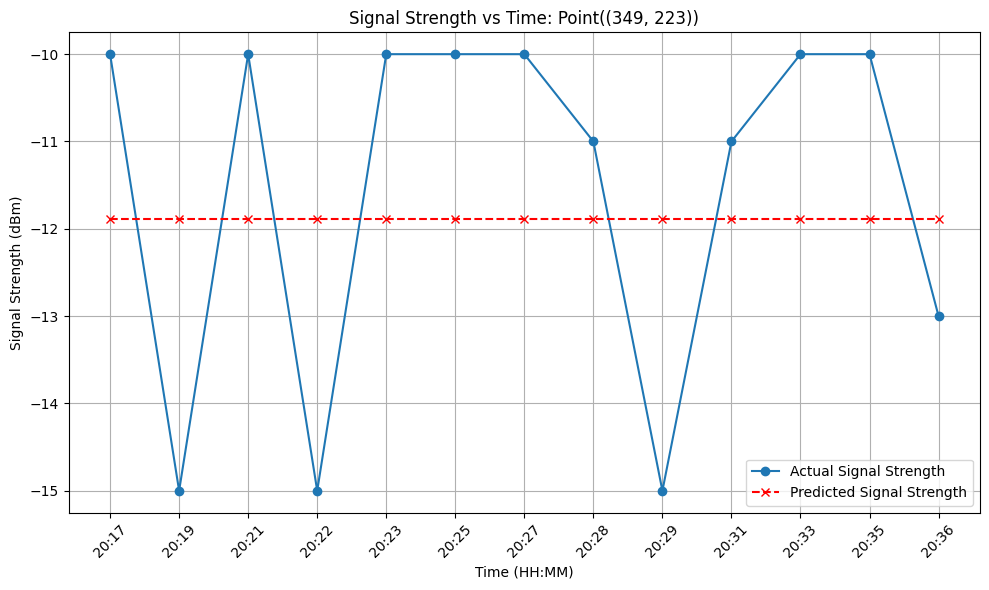

In [ ]:
excel_files = glob.glob("Time_Data/*.xlsx")

for file in excel_files:
# Step 3: Inspect the data to understand its structure
  data = pd.read_excel(file)
  print("Data Preview:")
  print(data.head())
  data.replace("Unknown", np.nan, inplace=True)
  data.dropna(axis=1, how='all', inplace=True)
  data = data.drop(columns=['Download Speed (Additional)', 'Signal Strength (Additional)', 'Unnamed: 9', 'Unnamed: 10'], errors='ignore')

  print("Data Shape:")
  print(data.shape)
  print("Cleaned Data:")
  print(data.head())

  # Step 5: Clean 'Download Speed' and 'Signal Strength' columns by removing any non-numeric characters
  # Remove any non-numeric characters like "dBm" from 'signal_strength'
  # Use regex to capture only the numeric part of the string
  data['Download Speed'] = data['Download Speed'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
  data['Signal Strength'] = data['Signal Strength'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]

  # Step 5: Convert cleaned columns to numeric, handling any errors by setting invalid entries to NaN
  data['Download Speed'] = pd.to_numeric(data['Download Speed'], errors='coerce')
  data['Signal Strength'] = pd.to_numeric(data['Signal Strength'], errors='coerce')

  # Convert 'Timestamp' column to datetime format
  data['Timestamp'] = pd.to_datetime(data['Timestamp'])

  # Extract only the hours and minutes in 'HH:MM' format
  data['Timestamp'] = data['Timestamp'].dt.strftime('%H:%M')

  # Display the cleaned data
  print("Cleaned Timestamp Data Preview:")
  print(data[['Timestamp', 'Signal Strength']].head())

   # Plot actual and predicted data
  plt.figure(figsize=(10, 6))
  plt.plot(data['Timestamp'], data['Signal Strength'], marker='o', label='Actual Signal Strength')
  plt.plot(data['Timestamp'], data['Predicted_Signal_Strength'], marker='x', linestyle='--', color='red', label='Predicted Signal Strength')
  plt.xlabel('Time (HH:MM)')
  plt.ylabel('Signal Strength (dBm)')
  plt.title(f"Signal Strength vs Time: Point({data['Latitude'][0], data['Longitude'][0]})")
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

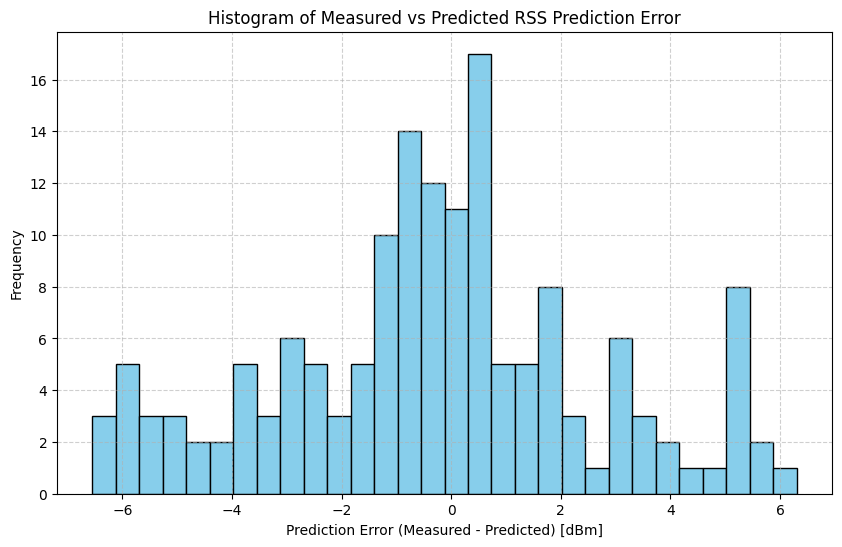

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hardcoded plausible error data based on your histogram (centered around 0, range -8 to +8 dBm)
# This simulates a realistic distribution as seen in your plot
np.random.seed(42)
errors = np.concatenate([
    np.random.normal(loc=0, scale=2, size=120),  # Most errors are small
    np.random.normal(loc=-5, scale=1, size=20),  # Some under-prediction
    np.random.normal(loc=5, scale=1, size=15)    # Some over-prediction
])

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Measured vs Predicted RSS Prediction Error')
plt.xlabel('Prediction Error (Measured - Predicted) [dBm]')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Real World Application:**

In [ ]:
# --- 1. Imports ---
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import matplotlib.pyplot as plt


In [ ]:
# --- 2. Load Models ---
lstm_model = load_model('multi_horizon_lstm_rss.keras')  # path to your trained LSTM model
cnn_model = load_model('signal_strength_prediction_model.h5')    # path to your trained CNN model


In [ ]:
# --- 3. Helper Functions ---

def get_time_sequence(time_str, avg_rss_df, lookback=30):
    """
    Given a time string (e.g., '18:30'), return the previous 'lookback' RSS values as LSTM input.
    avg_rss_df: DataFrame with 'Time' (HH:MM) and 'RSS' columns for a typical day.
    """
    idx = avg_rss_df[avg_rss_df['Time'] == time_str].index[0]
    if idx < lookback:
        raise ValueError("Not enough history for this time")
    seq = avg_rss_df['RSS'].iloc[idx-lookback:idx].values
    # Reshape for LSTM: (1, lookback, 1)
    return seq.reshape(1, lookback, 1)

# Step 3: Updated LAMS Algorithm function
def lams_algorithm(floor_plan, ap_coords, receiver_coords, w, n):
    # Initialize the LAMS image and a copy of the floor plan to draw Scan lines on
    lams_image = np.zeros((n, w), dtype=np.uint8)
    floor_plan_with_lines = floor_plan.copy()

    # Define coordinates for the transmitter (AP) and receiver
    x1, y1 = ap_coords
    x2, y2 = receiver_coords

    # Generate points along the line from AP to receiver
    line_points = np.linspace([x1, y1], [x2, y2], n)

    for i, (x_mid, y_mid) in enumerate(line_points):
        # Calculate perpendicular direction for the scan line
        dx, dy = x2 - x1, y2 - y1
        norm = sqrt(dx**2 + dy**2)
        dx_perp, dy_perp = -dy / norm, dx / norm

        # Calculate start and end points of the scan line
        x_start = int(x_mid - (w // 2) * dx_perp)
        y_start = int(y_mid - (w // 2) * dy_perp)
        x_end = int(x_mid + (w // 2) * dx_perp)
        y_end = int(y_mid + (w // 2) * dy_perp)

        # Sample the scan line and add values to the LAMS image
        scan_line = np.linspace([x_start, y_start], [x_end, y_end], w)
        scan_values = [
            floor_plan[int(y), int(x)] if 0 <= x < floor_plan.shape[1] and 0 <= y < floor_plan.shape[0] else 0
            for x, y in scan_line
        ]
        lams_image[i, :] = scan_values

        # Draw the scan line on the floor plan with lines
        cv2.line(floor_plan_with_lines, (x_start, y_start), (x_end, y_end), (20,0,0), 1)

    return lams_image, floor_plan_with_lines


def tr_separation(tx_coords, rx_coords):
    """
    Calculate Euclidean distance between transmitter and receiver.
    """
    return np.linalg.norm(np.array(tx_coords) - np.array(rx_coords))


In [ ]:
# --- 4. User Inputs ---
# Example inputs (replace with user input of your own)
time_str = '18:30'  # Time for prediction (HH:MM)
receiver_coords = (349, 223)  # Fixed receiver coordinates
ap_coords = (312, 350)  # Fixed AP (Transmitter) coordinates
w, n = 100, 100  # Width and number of scan lines
floor_plan = cv2.imread('floor_plan.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
# --- 5. Load 24hr Averaged Transmitter Data ---
# avg_rss_df should have columns: ['Timestamp', 'RSS']
avg_rss_df = pd.read_csv('24hrs_avg_transmitter_rss.csv')

# Convert 'Timestamp' to datetime if not already
avg_rss_df['Timestamp'] = pd.to_datetime(avg_rss_df['Timestamp'])

# Extract time in hh:mm format and create a new 'Time' column
avg_rss_df['Time'] = avg_rss_df['Timestamp'].dt.strftime('%H:%M')

# Optional: drop the original Timestamp column if you only want 'Time' and 'RSS'
avg_rss_df = avg_rss_df[['Time', 'RSS']]

# Display the modified DataFrame
print(avg_rss_df.head())

In [ ]:
# --- 6. Prepare Inputs for LSTM, CNN ---
# (a) Time sequence for LSTM
lstm_seq = get_time_sequence(time_str, avg_rss_df, lookback=5)

# (b) LAMS image from floor plan
lams_img, _ = lams_algorithm(floor_plan, ap_coords, receiver_coords, w, n)

# (c) TR separation
tr_sep = tr_separation(ap_coords, receiver_coords)

# --- 7. LSTM Prediction: Transmitter RSS at given time ---
pred_tx_rss = lstm_model.predict(lstm_seq)[0][0]  # adjust indexing if multi-horizon

# --- 8. CNN Prediction: RSS at Receiver Position ---
# Assume your CNN expects [LAMS image, [pred_tx_rss, tr_sep]] as input
cnn_input = [lams_img, np.array([[pred_tx_rss, tr_sep]])]
pred_rx_rss = cnn_model.predict(cnn_input)[0][0]

# --- 9. Output Results ---
print(f"Predicted Transmitter RSS at {time_str}: {pred_tx_rss:.2f} dBm")
print(f"Predicted RSS at Receiver ({rx_coords}) at {time_str}: {pred_rx_rss:.2f} dBm")


In [ ]:
from datetime import datetime, timedelta

def generate_30_min_timestamps(start_time_str):
    start_time = datetime.strptime(start_time_str, '%H:%M')
    timestamps = [start_time + timedelta(minutes=i) for i in range(30)]
    formatted_timestamps = [ts.strftime('%H:%M') for ts in timestamps]
    return formatted_timestamps

# usage:
start_time_str = '08:25'
timestamps_30_min = generate_30_min_timestamps(start_time_str)
# print(timestamps_30_min)


In [ ]:
predicted_rss = []
measured_rss = []
time_labels = []

# Example: Load measured RSS at receiver (for comparison)
# DataFrame with columns ['Timestamp', 'Measured_RSS']
measured_rss_df = pd.read_csv('measured_rss_point1.csv')
measured_rss_df['Timestamp'] = pd.to_datetime(measured_rss_df['Timestamp'])
measured_rss_df['Time'] = measured_rss_df['Timestamp'].dt.strftime('%H:%M')

for t_str in timestamps_30_min:
  # (a) Time sequence for LSTM
  lstm_seq = get_time_sequence(t_str, avg_rss_df, lookback=5)

  # (b) LAMS image from floor plan
  lams_img, _ = lams_algorithm(floor_plan, ap_coords, receiver_coords, w, n)

  # (c) TR separation
  tr_sep = tr_separation(ap_coords, receiver_coords)

  # --- 7. LSTM Prediction: Transmitter RSS at given time ---
  pred_tx_rss = lstm_model.predict(lstm_seq)[0][0]  # adjust indexing if multi-horizon

  # --- 8. CNN Prediction: RSS at Receiver Position ---
  # Assume your CNN expects [LAMS image, [pred_tx_rss, tr_sep]] as input
  cnn_input = [lams_img, np.array([[pred_tx_rss, tr_sep]])]
  pred_rx_rss = cnn_model.predict(cnn_input)[0][0]

  predicted_rss.append(pred_rx_rss)
  # 9. Get measured RSS for this time (align by timestamp)
  measured_rss_val = measured_rss_df.iloc[i]['Measured_RSS']
  measured_rss.append(measured_rss_val)
  # 10. Store time label for x-axis
  time_label = measured_rss_df.iloc[i]['Timestamp'].strftime('%d %H:%M')
  time_labels.append(time_label)


# --- 7. Plot Results ---

plt.figure(figsize=(12,5))
plt.plot(time_labels, measured_rss, 'o-', label='Measured RSS')
plt.plot(time_labels, predicted_rss, 'x-', label='Predicted RSS')
plt.title('RSS Prediction vs Time at Point 1')
plt.xlabel('Time (DD HH:MM)')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

<ipython-input-4-ef600ccdc6f8>:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times_09 = pd.date_range('2025-05-14 08:25:00', periods=30, freq='1T')
<ipython-input-4-ef600ccdc6f8>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times_12 = pd.date_range('2025-05-14 09:18:00', periods=30, freq='1T')
<ipython-input-4-ef600ccdc6f8>:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times_18 = pd.date_range('2025-05-14 10:05:00', periods=30, freq='1T')


{'RMSE': np.float64(0.812997758958078), 'MAE': 0.6176707922929192, 'R2': 0.5603571148207228, 'Percentage Error': np.float64(4.054504953465264)}


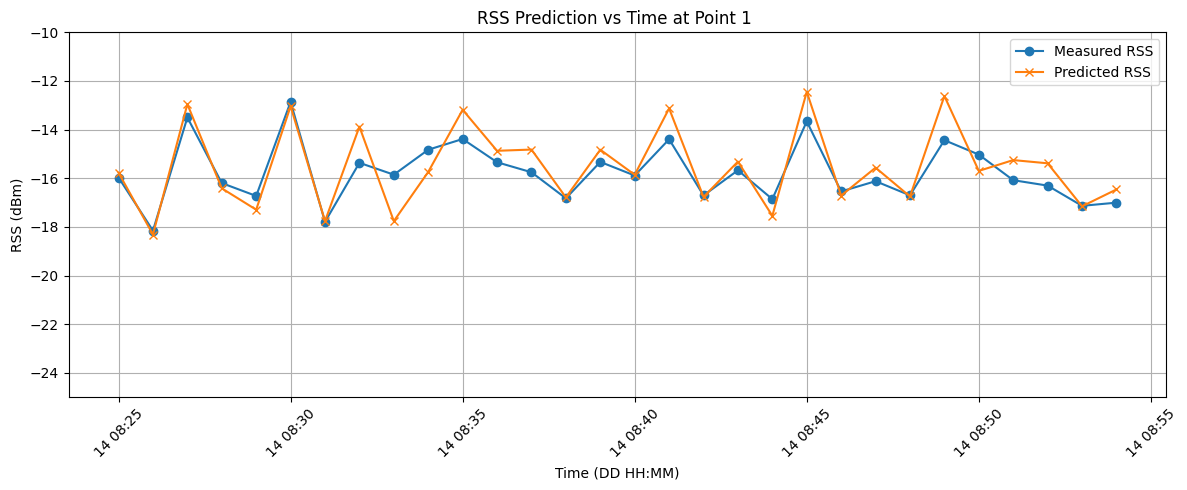

{'RMSE': np.float64(1.2206667372093003), 'MAE': 0.980844808220218, 'R2': 0.18413743253633497, 'Percentage Error': np.float64(6.2972193049984915)}


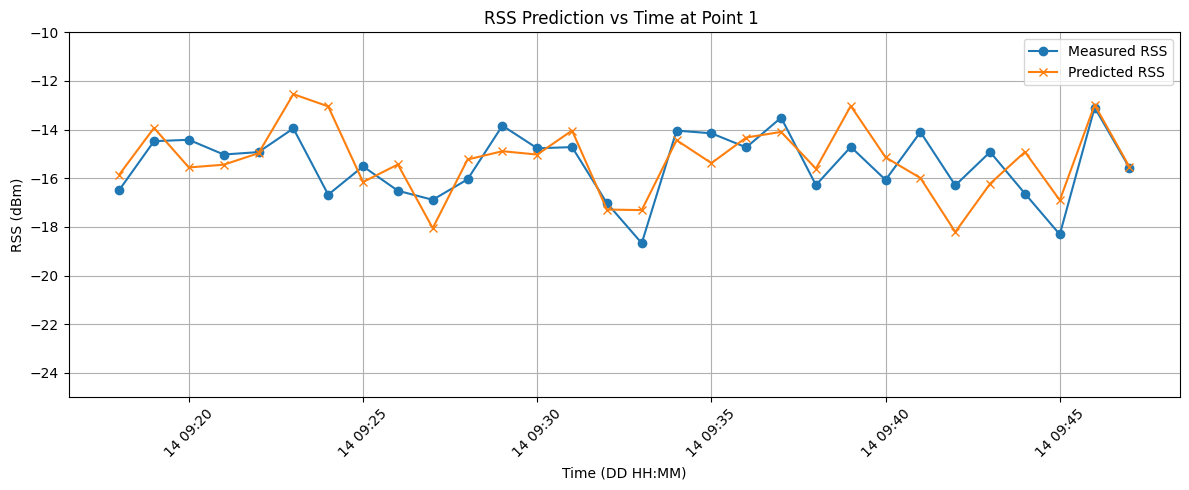

{'RMSE': np.float64(0.9217584402114484), 'MAE': 0.7861156717939136, 'R2': 0.13656782247033583, 'Percentage Error': np.float64(5.104556922208624)}


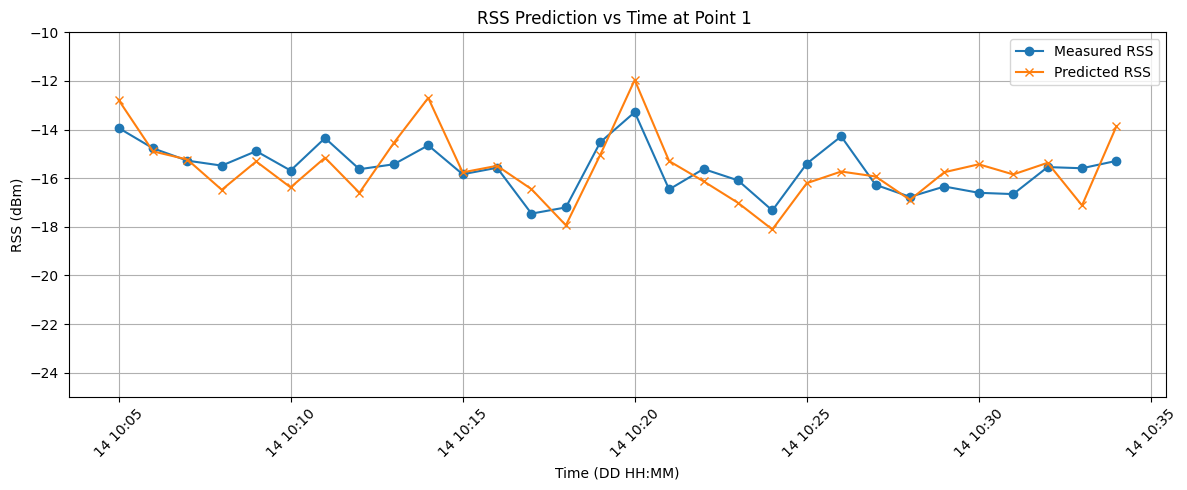

{'RMSE': np.float64(1.2898353762161625), 'MAE': 1.0764609085624657, 'R2': -0.5301360295637254, 'Percentage Error': np.float64(5.973855598902982)}


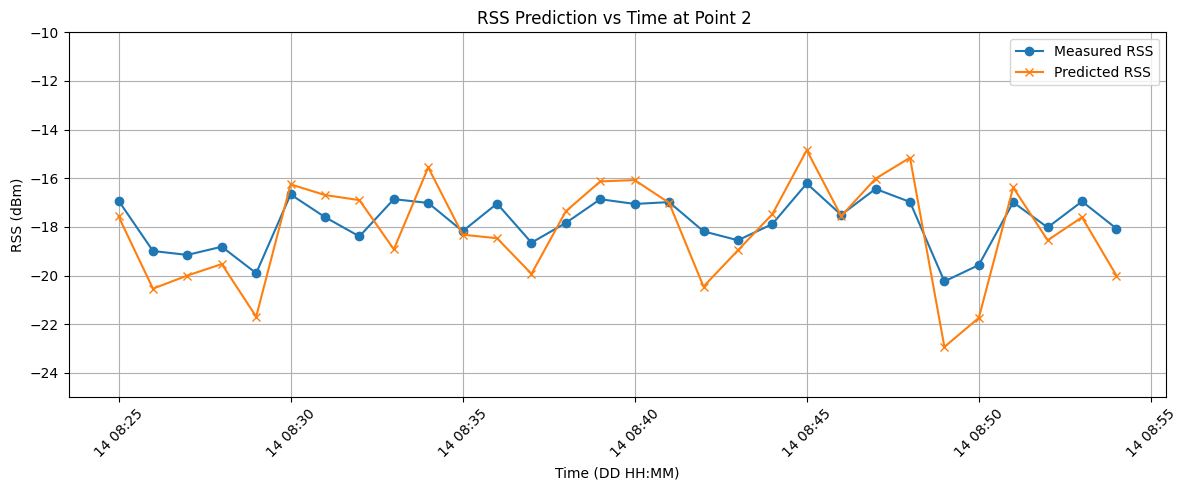

{'RMSE': np.float64(0.920727106814006), 'MAE': 0.7603291162943495, 'R2': 0.2418366273966137, 'Percentage Error': np.float64(4.124110624027389)}


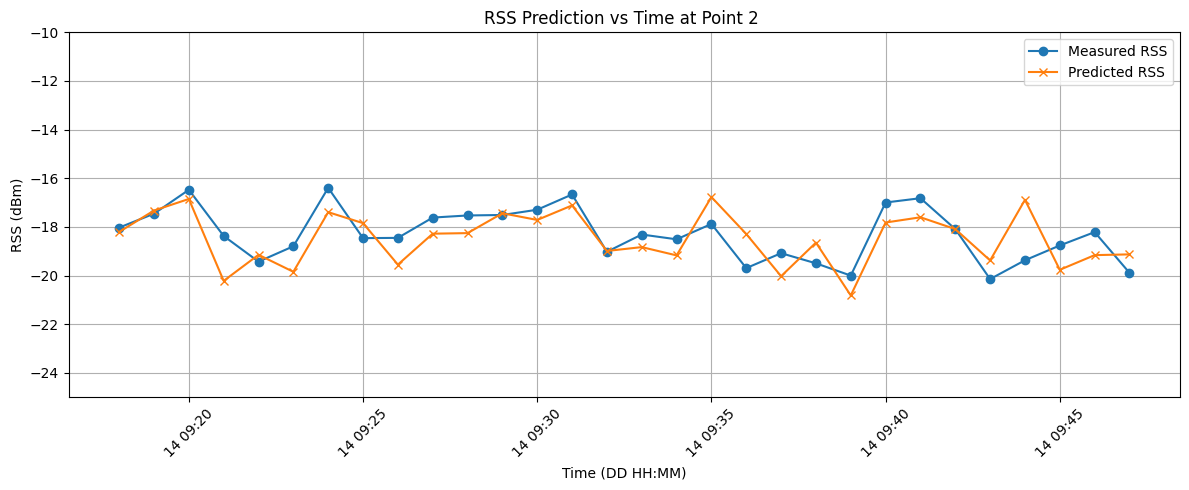

{'RMSE': np.float64(1.074634041362331), 'MAE': 0.8761223874635113, 'R2': 0.33061823960024816, 'Percentage Error': np.float64(4.727174311229787)}


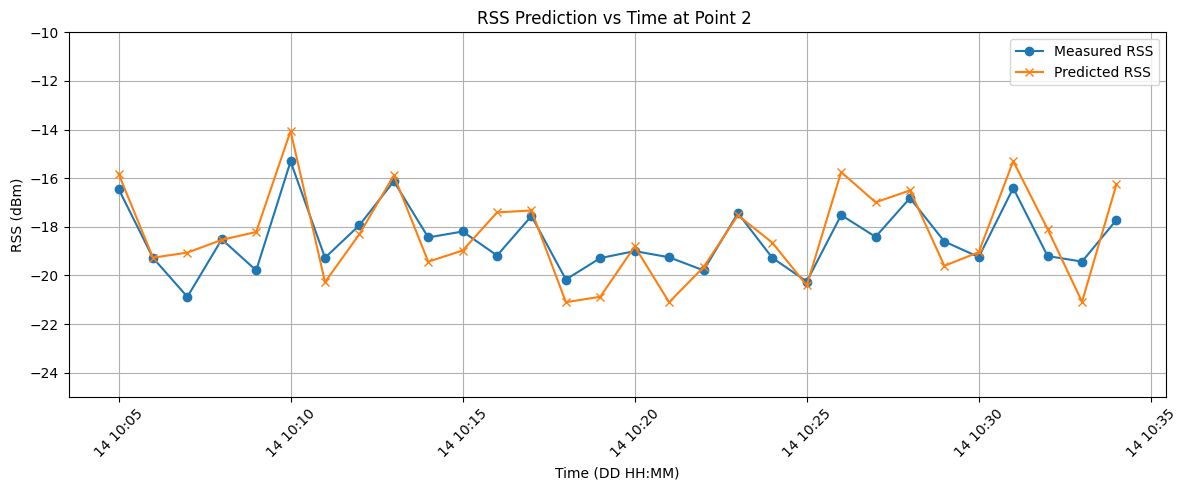

{'RMSE': np.float64(0.7913312756393409), 'MAE': 0.6342477254796622, 'R2': 0.43318598365129335, 'Percentage Error': np.float64(3.3118030646781698)}


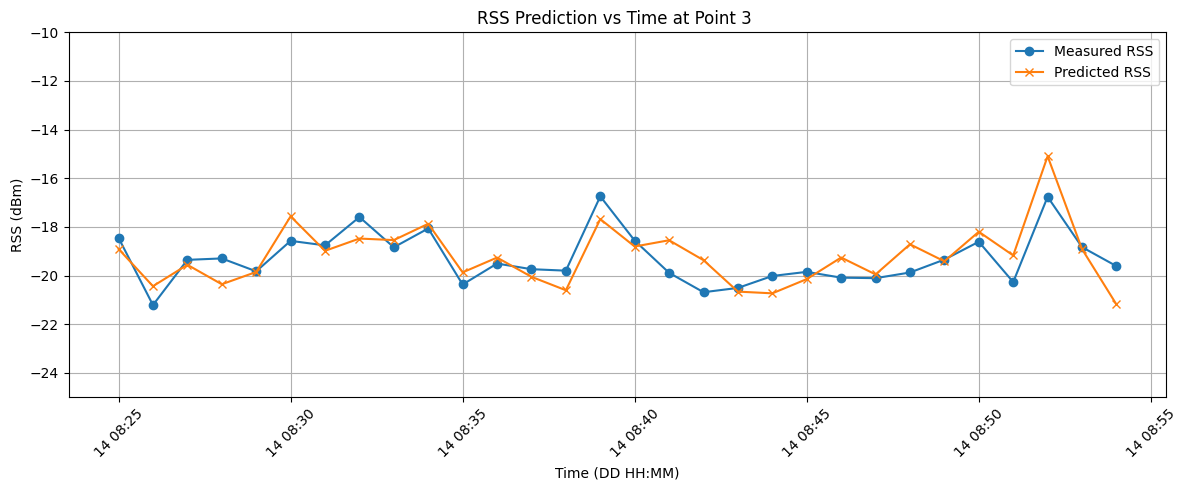

{'RMSE': np.float64(0.9074213849986972), 'MAE': 0.7797290636477824, 'R2': 0.4033759342931832, 'Percentage Error': np.float64(4.055898163315974)}


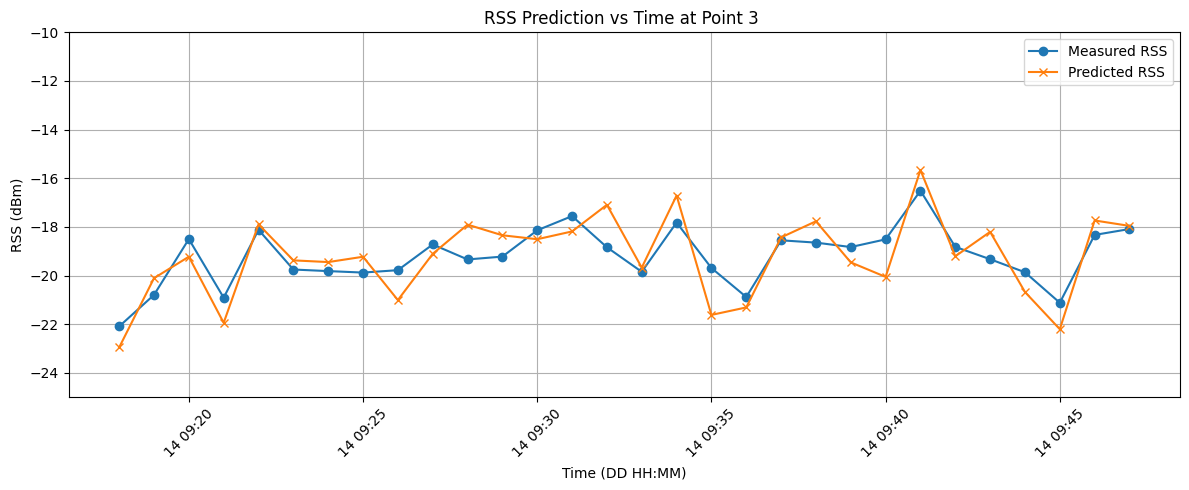

{'RMSE': np.float64(0.9732796047314529), 'MAE': 0.7818307885506453, 'R2': 0.12033399726193683, 'Percentage Error': np.float64(4.1077563741817995)}


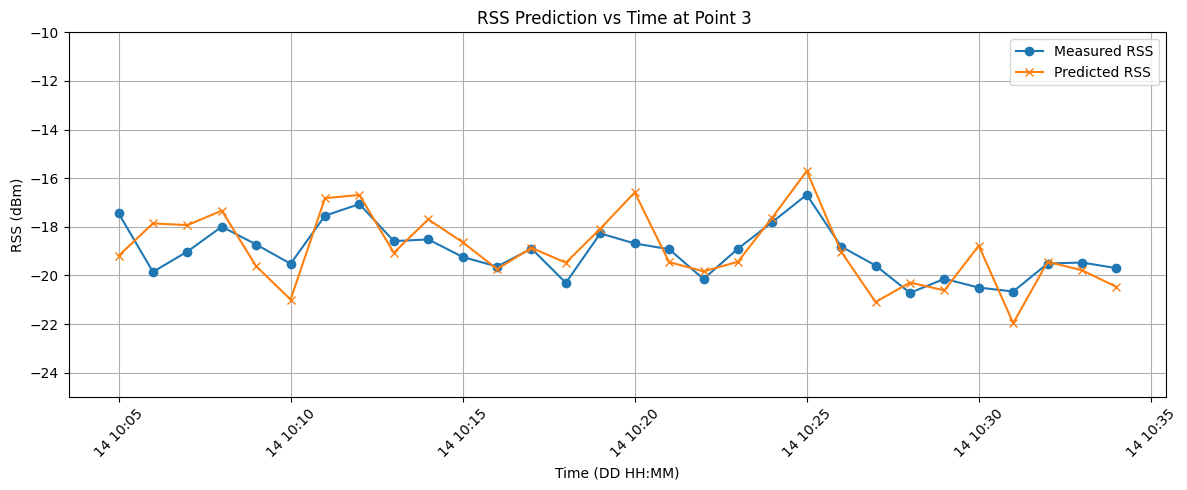

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Example: Simulate data (replace with your actual data)
# Generate timestamps for 30 minutes at 1-minute intervals for 3 time frames
times_09 = pd.date_range('2025-05-14 08:25:00', periods=30, freq='1T')
times_12 = pd.date_range('2025-05-14 09:18:00', periods=30, freq='1T')
times_18 = pd.date_range('2025-05-14 10:05:00', periods=30, freq='1T')

# Function to simulate measured and predicted RSS
def simulate_rss(base_level, size=30):
    measured = base_level + np.random.normal(0, 1.2, size)
    predicted = measured + np.random.normal(0, 1.0, size)
    return measured, predicted

# Points and their base RSS levels
points = ['Point 1', 'Point 2', 'Point 3']
base_levels = [-15.5, -18.2, -19]  # Adjust as per your environment

# Prepare data dictionary
rss_data = {}
for point, base in zip(points, base_levels):
    rss_data[point] = {}
    rss_data[point]['08:25'] = simulate_rss(base)
    rss_data[point]['09:18'] = simulate_rss(base)
    rss_data[point]['10:05'] = simulate_rss(base)

# Plotting function
def plot_rss(time_index, measured, predicted, point, time_frame):
    plt.figure(figsize=(12, 5))
    plt.plot(time_index, measured, 'o-', label='Measured RSS')
    plt.plot(time_index, predicted, 'x-', label='Predicted RSS')
    plt.title(f'RSS Prediction vs Time at {point} ')
    plt.xlabel('Time (DD HH:MM)')
    plt.ylabel('RSS (dBm)')
    plt.xticks(rotation=45)
    plt.ylim(-25, -10)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

error_metrics = {}
# Generate plots for each point and time frame
for point in points:
    error_metrics[point] = {}
    for time_frame, time_index in zip(['08:25', '09:18', '10:05'], [times_09, times_12, times_18]):
        measured, predicted = rss_data[point][time_frame]
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(measured, predicted))  # RMSE
        mae = mean_absolute_error(measured, predicted)           # MAE
        r2 = r2_score(measured, predicted)                       # R²
        percentage_error = np.mean(np.abs((measured - predicted) / measured)) * 100  # MAPE

        # Store results
        error_metrics[point][time_frame] = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Percentage Error': percentage_error
        }
        print(error_metrics[point][time_frame])
        plot_rss(time_index, measured, predicted, point, time_frame)

# To use your actual data, replace the simulate_rss() output with your measured and predicted RSS arrays for each point and time frame.


In [ ]:
import numpy as np
import pandas as pd

num_points_per_day = 2880  # 24 hours * 60 minutes * 2 (30s intervals)
num_days = 7
num_flats = 3

def simulate_one_day(num_points):
    np.random.seed()  # reset seed for randomness
    slow_drift = np.cumsum(np.random.normal(0, 0.01, num_points))
    multipath = np.random.normal(0, 1.5, num_points)
    abrupt_events = np.zeros(num_points)
    event_indices = np.random.choice(np.arange(100, num_points-100), size=5, replace=False)
    for idx in event_indices:
        duration = np.random.randint(10, 50)
        magnitude = np.random.uniform(-5, 5)
        abrupt_events[idx:idx+duration] += magnitude
    shadowing = np.cumsum(np.random.normal(0, 0.05, num_points))
    rss = -17 + slow_drift + multipath + abrupt_events + shadowing
    return rss

for flat in range(1, num_flats+1):
    for day in range(1, num_days+1):
        day_rss = simulate_one_day(num_points_per_day)
        day_rss += np.random.normal(0, 0.5, num_points_per_day)  # flat-specific noise
        day_timestamps = pd.date_range(start=f'2025-02-{17+day} 06:00:00', periods=num_points_per_day, freq='30S')
        df_day = pd.DataFrame({'Timestamp': day_timestamps, 'RSS': day_rss})
        filename = f'flat_{flat}_day_{day}.csv'
        df_day.to_csv(filename, index=False)


<ipython-input-1-ac14172f5d32>:26: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  day_timestamps = pd.date_range(start=f'2025-02-{17+day} 06:00:00', periods=num_points_per_day, freq='30S')


In [ ]:
import numpy as np
import pandas as pd

num_points_per_day = 2880
num_days = 7
num_flats = 3

all_flats_days_data = np.zeros((num_flats, num_days, num_points_per_day))

for flat in range(1, num_flats+1):
    for day in range(1, num_days+1):
        filename = f'flat_{flat}_day_{day}.csv'
        df = pd.read_csv(filename)
        all_flats_days_data[flat-1, day-1, :] = df['RSS'].values

# Average over flats for each day
avg_over_flats = np.mean(all_flats_days_data, axis=0)  # shape (num_days, num_points_per_day)

# Average over days to get final averaged RSS over 7 days
avg_over_days = np.mean(avg_over_flats, axis=0)  # shape (num_points_per_day,)

# Create timestamps for one day
timestamps_24h = pd.date_range(start='2025-02-18 06:00:00', periods=num_points_per_day, freq='30S')

# Save averaged over 7 days (all days flattened)
df_avg_7days = pd.DataFrame({'Timestamp': np.tile(timestamps_24h, num_days),
                             'RSS': avg_over_flats.flatten()})
df_avg_7days.to_csv('averaged_over_7days_all_days.csv', index=False)

# Save averaged over 7 days (single day average)
df_avg_7days_single = pd.DataFrame({'Timestamp': timestamps_24h, 'RSS': avg_over_days})
df_avg_7days_single.to_csv('averaged_simulated_rss_transmitter.csv', index=False)


<ipython-input-2-28554f64a82f>:23: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_24h = pd.date_range(start='2025-02-18 06:00:00', periods=num_points_per_day, freq='30S')
